# Audience Decode: Behavioral Analysis Project

**Team Members:** Yelena Shabanova 320991, Alena Seliutina 323591, Luis Fernando Henriquez Patino 314661

---

## Introduction

This project aims to analyze viewer engagement and behavioral patterns from the `viewer_interactions.db` dataset. "Audience Decode" goal is not to predict individual ratings, but to explore and model audience behavior.

We will use **Unsupervised Learning (Clustering)** to achieve this, focusing on:
1.  **User Segmentation:** Identifying distinct groups of users based on their rating behaviors.
2.  **Behavioral Analysis:** Understanding how these groups interact with different types of content and how preferences may evolve.

**Note on "Genre":** The project description mentions "genres," but this information is not provided in database. We made our definition of content types(pseudo-genres) based on features given in movie data to proceed with analysis.

## Table of contents
1. **ENVIRONMENT SETUP** 
2. **DATA LOADING**  

3. **EXPLANATORY DATA ANALYSIS**  
   3.1 EDA: USER    
   3.2 EDA: MOVIES  

4. **DATA PREPROCESSING**  
   4.1 User Feature Matrix  
   4.2 Movie Feature Matrix  
   4.3 Preprocessing Summary  

5. **MOVIE CLUSTERING**  
   5.1 Selecting the Number of Clusters  
   5.2 Fitting K-Means Model  
   5.3 PCA Reduction for Visualization  
   5.4 Cluster Interpretation  
   5.5 Naming Pseudo-Genres  

6. **USER CLUSTERING**  
   6.1 K-MEANS  
   6.2 DBSCAN  
   6.3 BIRCH  
   6.4 MODEL COMPARISON  
   6.5 NAMING USER CLUSTERS

7. **USER-MOVIE PREFERENCES**  
    7.1 Merge Interactions with Clusters  
    7.2 Building Matrices  
    7.3 Temporal Analysis  
    7.4 Project Discoveries

8. **CONCLUSIONS**  

## SECTION 1: ENVIRONMENT SETUP

First, we import all necessary libraries for data loading, analysis, visualization, and machine learning.

In [149]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# Clustering Models
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import Birch

# Model Evaluation
from sklearn.metrics import silhouette_score

# Images set up
os.makedirs("images", exist_ok=True)

# Set styles and options
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)
sns.set_palette("Set2")
%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("Libraries are imported")

Libraries are imported


## SECTION 2: DATA LOADING

We connect to the database (`viewer_interactions.db`) and load the key tables into pandas DataFrames.

* `user_statistics`: Pre-computed behavioral data for each user.
* `movie_statistics`: Pre-computed data for each movie.
* `movies`: Basic metadata for movies (title, year).

In [150]:
DB_PATH = 'viewer_interactions.db'

# Connect to database
conn = sqlite3.connect(DB_PATH)

# Load main tables
df_users = pd.read_sql_query("SELECT * FROM user_statistics", conn) # primary table for user clustering
df_movies = pd.read_sql_query("SELECT * FROM movie_statistics", conn) # for EDA and definition of genres
df_movies_meta = pd.read_sql_query("SELECT * FROM movies", conn)

# Close connection
conn.close()
print("Database connection closed.")
print(f"Loaded {len(df_users)} users")
print(f"Loaded {len(df_movies)} movies")

Database connection closed.
Loaded 438780 users
Loaded 16015 movies


In [151]:
# Display the first few rows of the user data
print("User Statistics Head:")
display(df_users.head())

User Statistics Head:


,customer_id,total_ratings,avg_rating,std_rating,min_rating,max_rating,unique_movies,first_rating_date,last_rating_date,activity_days
0,1965326,8.000,3.250,0.886,2.000,5.000,8.000,2004-08-11,2005-06-06,299.000
1,506434,1.000,4.000,NaN,4.000,4.000,1.000,2005-08-02,2005-08-02,0.000
2,1365167,3.000,4.667,0.577,4.000,5.000,3.000,2004-11-16,2005-01-19,64.000
3,396632,2.000,NaN,0.000,4.000,4.000,2.000,2004-07-07,2004-07-07,0.000
4,260614,3.000,4.333,0.577,4.000,5.000,3.000,2004-03-02,2004-10-13,NaN


## SECTION 3:  EDA
## 3.1 EDA: USER 

Before we can model behavior, we must understand it. We will perform an EDA to analyze the distributions of our data. Using (`user_statistics`), our goal is to understand viewer activity patterns and the distributions of key behavioral features. After we'll be able to cluster users based on shared patterns.

### **User Statistics Summary**

In [198]:
print("User Statistics Summary:")

user_statistics_summary = df_users[['total_ratings', 'avg_rating', 'std_rating', 'unique_movies', 'activity_days']].describe()

display(user_statistics_summary)
user_statistics_summary.to_csv("images/user_statistics_summary.csv")

User Statistics Summary:


,total_ratings,avg_rating,std_rating,unique_movies,activity_days
count,416841.000,416841.000,332528.000,416841.000,416841.000
mean,9.287,3.632,0.898,9.235,275.437
std,14.299,0.812,0.457,13.407,389.073
min,1.000,0.000,0.000,1.000,0.000
25%,2.000,3.185,0.645,2.000,0.000
50%,4.000,3.688,0.868,4.000,102.000
75%,11.000,4.000,1.155,11.000,408.000
max,764.000,6.000,3.536,764.000,3941.000


The table above provides an overview of key behavioral metrics for nearly half a million users. These features help us understand how viewers engage with the platform.

#### Interpretation:
- **`total_ratings`** is highly right-skewed: 50% rate only a few titles, while a small minority rate dozens or even hundreds.
- **`avg_rating`** varies widely across users, indicating different rating styles (e.g., harsh vs. generous raters).
- **`std_rating`** shows how consistent a user is in their scoring behavior.
- **`unique_movies`** closely mirrors `total_ratings`, confirming that users rarely re-rate the same film.
- **`activity_days`** captures long-term engagement and contributes additional behavioral context.

These statistics justify clustering users based on both activity and rating style, as the user base is highly heterogeneous.

### **Distribution of Total Ratings per User**

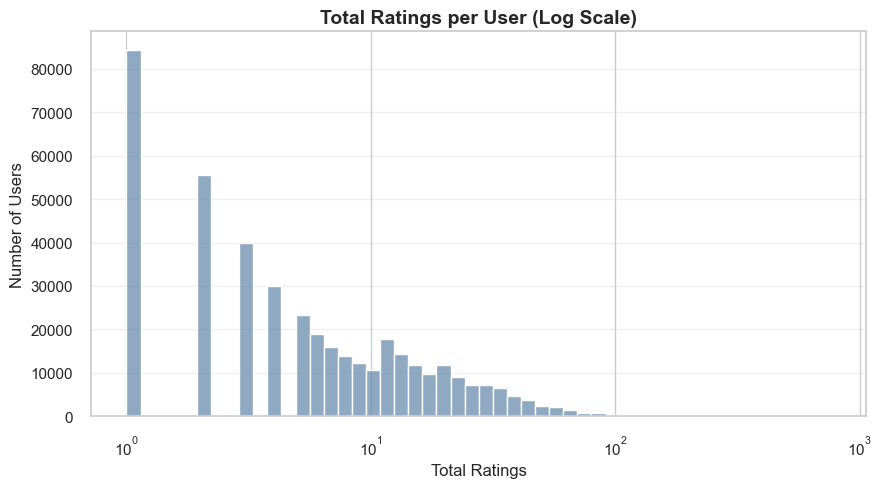

In [153]:
plt.figure(figsize=(10,5))
sns.histplot(df_users['total_ratings'], bins=50, log_scale=True, color="#6A8CAF")
plt.title("Total Ratings per User (Log Scale)", fontsize=14, fontweight='bold')
plt.xlabel("Total Ratings")
plt.ylabel("Number of Users")
plt.grid(axis='y', alpha=0.3)
plt.savefig("images/user_total_ratings_hist.png", dpi=300)
plt.show()

This histogram shows how many ratings each user has submitted. Because the distribution is extremely skewed, a logarithmic x-axis is used to visualize both the mass of low-activity users and the long tail of highly active users.

#### Interpretation
**Most users rate very few movies:**  
- The majority provide 1-5 ratings, indicating very light engagement. 
- 75% of users rate **fewer than 11** movies.

**Moderately active users are less common:**  
- Users rating **20–50 movies** form a noticeable but smaller segment.

**A long tail of "power users" exists but is extremely rare:**  
  - A tiny fraction rate **100+ movies**.  
  - The maximum user activity is **764 ratings**, but users above 100 ratings are so rare that they appear as nearly invisible bars on the log-scale histogram.

The contrast highlights the extremely uneven engagement pattern in the dataset. This justifies treating **user activity as a primary dimension** in later clustering.

### **Distribution of Average Rating Given**

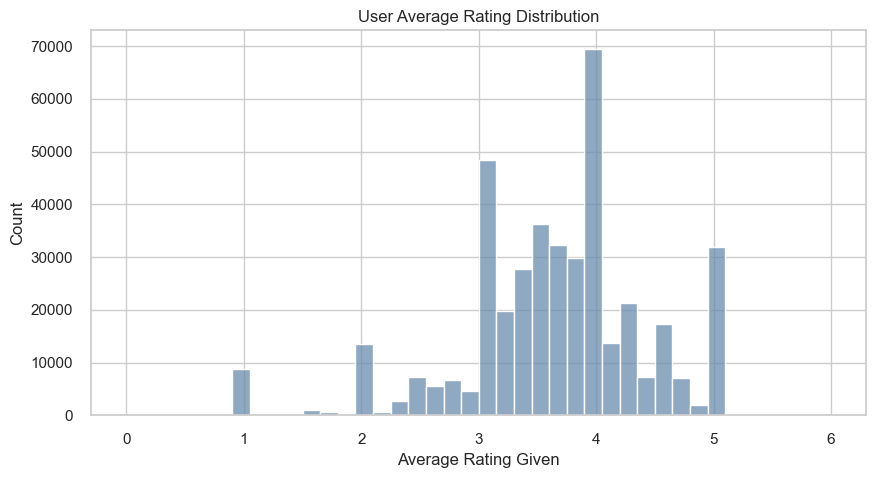

In [154]:
plt.figure(figsize=(10,5))
sns.histplot(df_users['avg_rating'], bins=40, kde=False, color="#6A8CAF")
plt.title("User Average Rating Distribution")
plt.xlabel("Average Rating Given")
plt.ylabel("Count")
plt.savefig("images/user_avg_rating_hist.png", dpi=300)
plt.show()

This histogram shows how generous or harsh users tend to be on average.

#### Interpretation
- Most users have an average rating between **3.0 and 4.0**, showing a general positive bias.
- Distinct spikes appear near whole-number values because ratings are inherently discrete (1–5).
- A noticeable number of users consistently give low or high average scores, suggesting meaningful variation in rating tendencies.

The histogram highlights diversity in rating style, which is another important dimension for user segmentation.

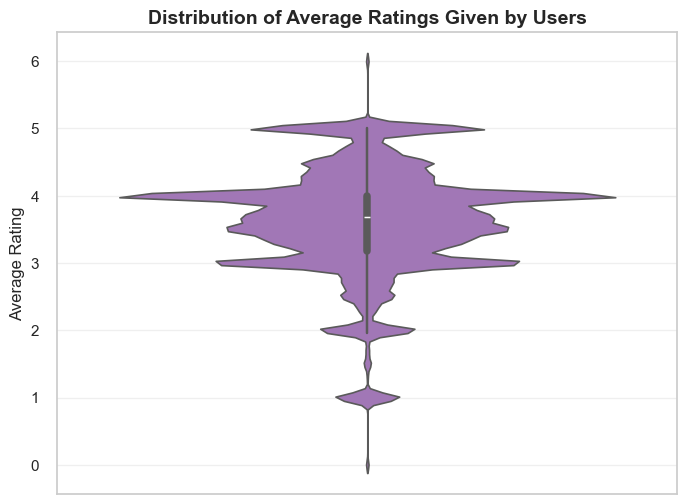

In [155]:
plt.figure(figsize=(8,6))
sns.violinplot(y=df_users['avg_rating'], inner='box', linewidth=1.2, color="#A56CC1")
plt.title("Distribution of Average Ratings Given by Users", fontsize=14, fontweight='bold')
plt.ylabel("Average Rating")
plt.grid(axis='y', alpha=0.3)
plt.savefig("images/user_avg_rating_violin.png", dpi=300)
plt.show()

The violin plot reveals the **full shape** of the distribution, complementing the histogram above.

#### Interpretation
- The densest region lies around **3.5–4.0**, confirming most users tend to rate positively.
- Thin tails at both extremes indicate a smaller group of consistently very harsh or very generous users.
- Distribution is not symmetric, the shape shows substantial variability, which becomes relevant when analyzing rating stability in next section.

 ### **Does User Activity Affect Rating Consistency?**

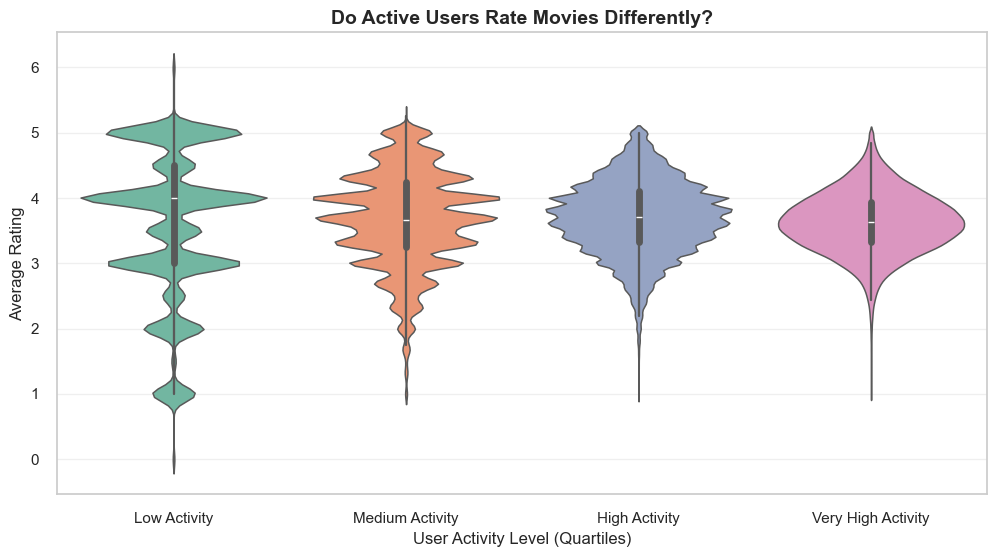

In [156]:
# Put users into activity quartiles
df_users['activity_bin'] = pd.qcut(df_users['total_ratings'], q=4, labels=["Low Activity", "Medium Activity", "High Activity", "Very High Activity"])

plt.figure(figsize=(12,6))
sns.violinplot(data=df_users, x='activity_bin', y='avg_rating', inner='box', linewidth=1.1, palette='Set2')

plt.title("Do Active Users Rate Movies Differently?", fontsize=14, fontweight='bold')
plt.xlabel("User Activity Level (Quartiles)")
plt.ylabel("Average Rating")
plt.grid(axis='y', alpha=0.3)
plt.savefig("images/user_activity_vs_rating_violin.png", dpi=300)
plt.show()

Users were grouped into **activity quartiles** based on `total_ratings`. A violin plot compares the **distribution** of average ratings across activity quartiles, showing the relationship between activity level and rating behavior.

#### Interpretation
**Mean ratings remain similar** across all activity levels — there is no linear shifts in average rating as user activity increases. *What does change is the spread:*
- **Low-activity users** display a much wider variability in average ratings, including extreme values.
- **Medium and high-activity users** concentrate closer to the 3–4 range, suggesting more stable and moderate scoring tendencies.
- **Very high-activity users** show the narrowest spread, indicating the most consistent behavior.

These differences demonstrate that **activity level influences behavioral consistency**, providing important nuance for clustering that should be included when clustering users.

### **Unique Movies vs Total Ratings**

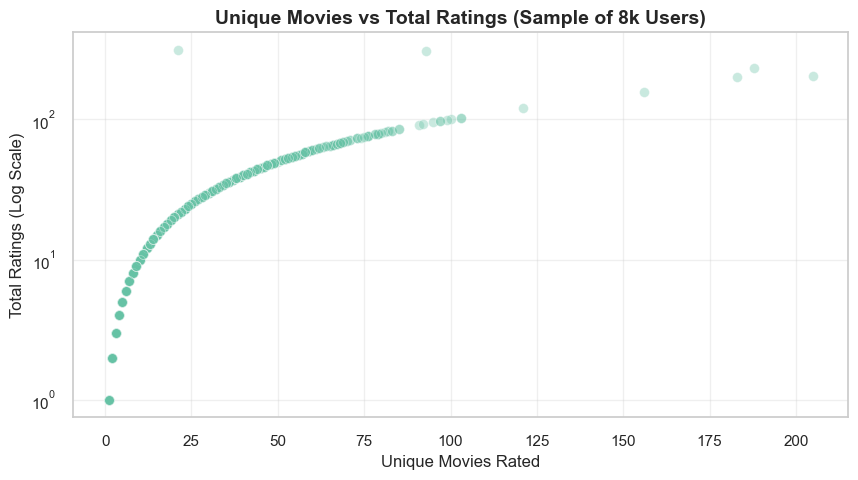

In [157]:
sample_users = df_users.sample(8000, random_state=42)

plt.figure(figsize=(10,5))
sns.scatterplot(data=sample_users, x='unique_movies', y='total_ratings', alpha=0.35, s=50)
plt.yscale("log")
plt.title("Unique Movies vs Total Ratings (Sample of 8k Users)", fontsize=14, fontweight='bold')
plt.xlabel("Unique Movies Rated")
plt.ylabel("Total Ratings (Log Scale)")
plt.grid(alpha=0.3)
plt.savefig("images/user_unique_vs_total_ratings_scatter.png", dpi=300)
plt.show()

In the scatterplot above each point represents one user, 
we're using a sample of 8,000 users to avoid overplotting.

#### Interpretation
- Points fall close to a curved line, showing a near-linear relationship between `unique_movies` and `total_ratings`.
- This confirms that users almost never re-rate the same movie.
- The log-scaled y-axis reveals variation across low-activity and high-activity users.

Because these two features are so tightly correlated, using both in clustering may introduce redundancy. The following heatmap confirms this insight quantitatively.

### **Correlation Between User Behavioral Features**

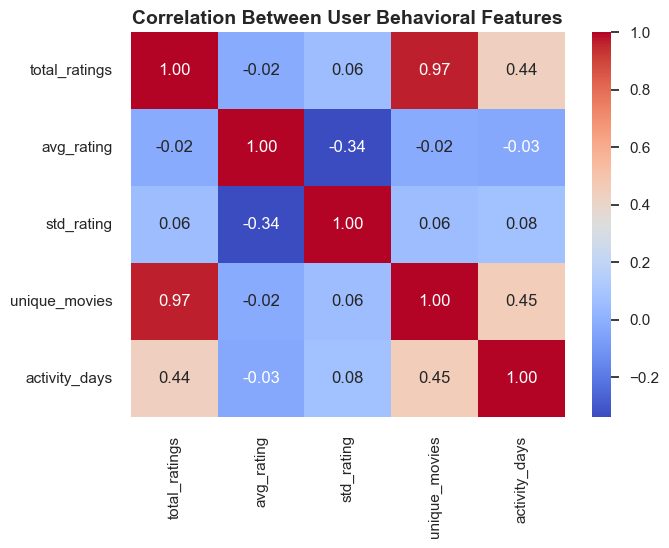

In [158]:
plt.figure(figsize=(7,5))
sns.heatmap(
    df_users[['total_ratings','avg_rating','std_rating','unique_movies','activity_days']].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Between User Behavioral Features", fontsize=14, fontweight='bold')
plt.savefig("images/user_features_correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

This heatmap summarizes linear relationships between the most relevant user behavior variables.

#### Interpretation
- **`total_ratings` and `unique_movies`** are almost perfectly correlated (ρ ≈ 0.97), indicating both measure the same behavior.
- **`avg_rating`** shows **no linear correlation** with user activity metrics (`total_ratings`, `unique_movies`, `activity_days`), meaning that on average, highly active users do not systematically rate movies higher or lower than less active users.
- **`std_rating`** is moderately negatively correlated with `avg_rating`, suggesting more generous users tend to be more consistent.
- **`activity_days`** shows a reasonable positive correlation with total ratings, consistent with expectations.

The heatmap guides feature selection for clustering:
- Avoid redundant variables (`total_ratings` and `unique_movies`).
- Combine **activity**, **consistency**, and **rating style** to capture distinct user personas.

## 3.2 EDA: MOVIES
Using (`movie_statistics`), our goal is to understand the movie popularity/rating patterns. Later we'll be able to divide movies into genre clusters based on explored patterns. This section answers core questions:  
	1.	How popular is each movie?    
	2.	How do movies tend to be rated?    
	3.	What relationships exist between popularity, rating, controversy, and release year?   
	4.	Are there meaningful patterns for clustering movies into “pseudo-genres”?    

### **Movie Statistics Summary**

In [197]:
print("Movie Statistics Summary:")
movie_statistics_summary = df_movies[['total_ratings', 'avg_rating', 'std_rating', 'year_of_release']].describe()
display(movie_statistics_summary)
movie_statistics_summary.to_csv("images/movie_statistics_summary.csv")

Movie Statistics Summary:


,total_ratings,avg_rating,std_rating,year_of_release
count,15215.000,15215.000,6847.000,11504.000
mean,260.044,3.000,1.258,1990.220
std,3696.939,1.312,0.789,16.334
min,1.000,0.000,0.000,1896.000
25%,1.000,2.000,0.707,1985.000
50%,1.000,3.000,1.222,1997.000
75%,2.000,4.000,1.732,2002.000
max,173598.000,6.000,4.243,2005.000


This table provides a quick overview of movie-level statistics derived from all user ratings. Before exploring the plots, it is useful to understand the distribution of movie-level metrics.

#### Interpretation

**Popularity is extremely skewed**:  
  - The median movie receives **1 rating**.  
  - 75% of movies receive **2 or fewer ratings**.  
  - Only a tiny fraction reach anywhere above **100 ratings**.
  - Few films reach **10 000+ ratings** (up to 173 598).

**Average ratings are centered around 3.0**, with a typical spread of about 1.3.
  This suggests that most movies receive moderately positive reviews.

**Rating variability (std_rating)** is usually between **0.7 and 1.3**, indicating that user opinions are generally consistent.  
  A few movies have very high variability, marking them as controversial.

**Release years span 1896–2005**, but the distribution is mostly flat and uncorrelated with other features.

Overall, the table confirms that the movie catalog contains **many obscure movies**, a moderate number of mid-known movies, and a **tiny number of blockbusters**.  
This extreme imbalance will strongly shape the interpretation of all following plots.

### **Distribution of Movie Popularity**

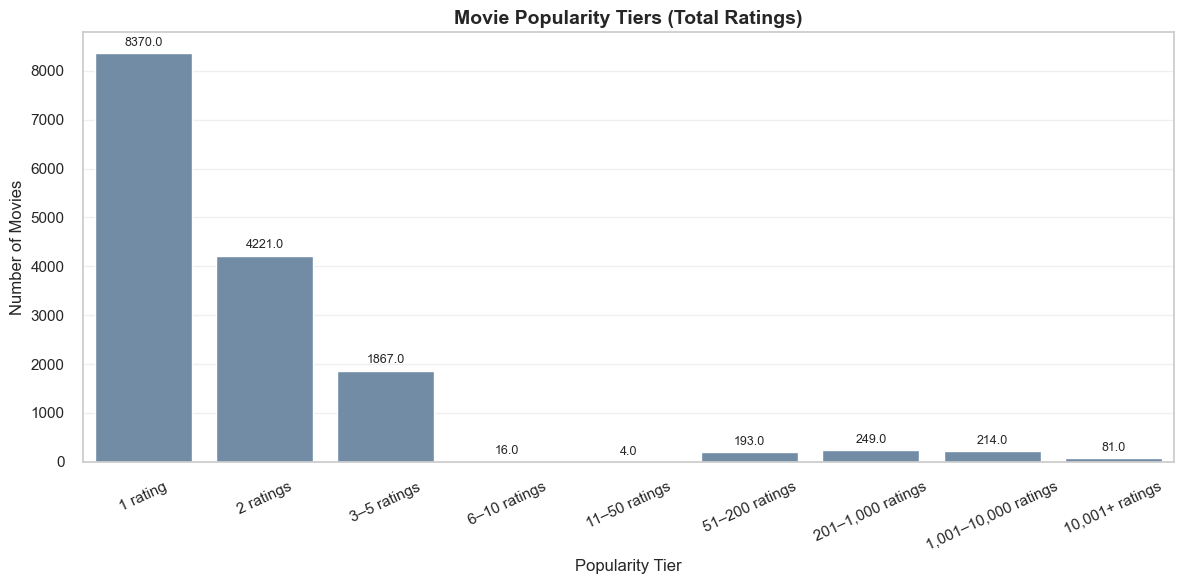

In [160]:
# Popularity tiers
bins = [0, 1, 2, 5, 10, 50, 200, 1000, 10000, df_movies['total_ratings'].max()]
labels = [
    "1 rating",
    "2 ratings",
    "3–5 ratings",
    "6–10 ratings",
    "11–50 ratings",
    "51–200 ratings",
    "201–1,000 ratings",
    "1,001–10,000 ratings",
    "10,001+ ratings"
]

df_movies['popularity_bin'] = pd.cut(df_movies['total_ratings'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(12,6))
ax = sns.countplot(data=df_movies, x='popularity_bin', order=labels, color="#6A8CAF")

plt.title("Movie Popularity Tiers (Total Ratings)", fontsize=14, fontweight='bold')
plt.xlabel("Popularity Tier")
plt.ylabel("Number of Movies")
plt.grid(axis='y', alpha=0.3)
plt.xticks(rotation=25)

# Annotate counts
for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(
        f"{height}",
        (patch.get_x() + patch.get_width() / 2., height),
        ha='center', va='bottom',
        fontsize=9,
        xytext=(0, 3),
        textcoords='offset points'
    )

plt.tight_layout()
plt.savefig("images/movie_popularity_tiers_bar.png", dpi=300)
plt.show()


#### Interpretation
To better understand the extreme skew in movie popularity, we group movies into meaningful popularity ranges.

- The first two categories, **“1 rating”** and **“2 ratings”**, dominate the catalog  
  (together they account for over **12,000 movies**): most titles were rated only once or twice.

- The **“3–5 ratings”** tier still contains a large number of movies (~1,800),  
  but after that the distribution drops off a cliff.

- The **“6–10”** and **“11–50”** tiers contain only a **handful** of titles, showing that very few movies sit in this intermediate space.

- Popularity then rises slightly again for:
  - **“51–200 ratings”** and **“201–1,000 ratings”** – a few hundred mid-popular films with a visible but not massive audience.
  - **“1,001–10,000 ratings”** – around two hundred well-known mainstream titles.
  - **“10,001+ ratings”** – about **80 true blockbusters**, with the most popular movie reaching **173,598 ratings**.

This tiered view makes the long-tail structure of the catalog clear:  
the platform is dominated by **very obscure movies**, with a much smaller group of mid-popular titles and a tiny set of highly popular blockbusters.  
Popularity is therefore a crucial dimension to include when clustering movies.

### **Distribution of Average Movie Ratings**

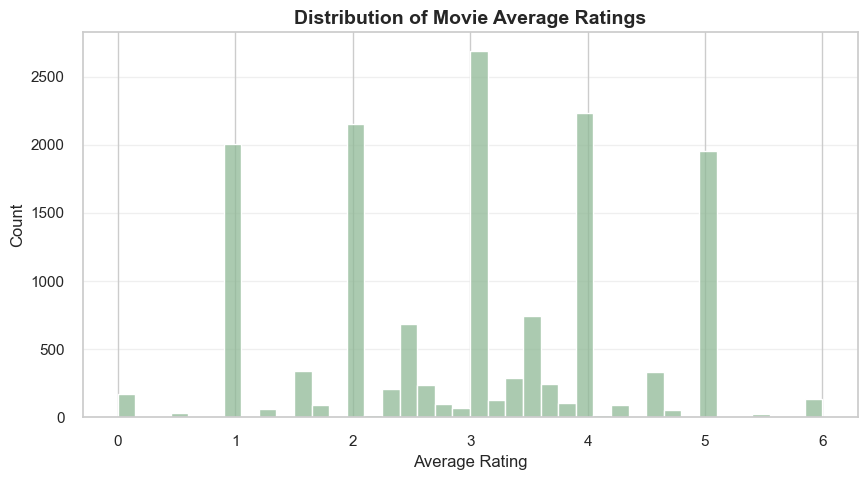

In [161]:
plt.figure(figsize=(10,5))
sns.histplot(df_movies['avg_rating'], bins=40, color="#8FB996")
plt.title("Distribution of Movie Average Ratings", fontsize=14, fontweight='bold')
plt.xlabel("Average Rating")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.savefig("images/movie_avg_rating_hist.png", dpi=300)
plt.show()

#### Interpretation

Movie average ratings cluster strongly around integer values (1, 2, 3, 4, 5), reflecting the discrete nature of the rating system.

Key observations:

- Most movies fall between **2.5 and 4.0**.  
- Very low-rated (<1.5) and very high-rated (>4.5) movies are rare.  
- Peaks at integer values occur because movies with very few ratings often have an average equal to their single rating.

Overall, movie quality scores are moderately positive, and extremely negative or extremely positive movies are uncommon.

### **Rating Variability (Controversy) Distribution**

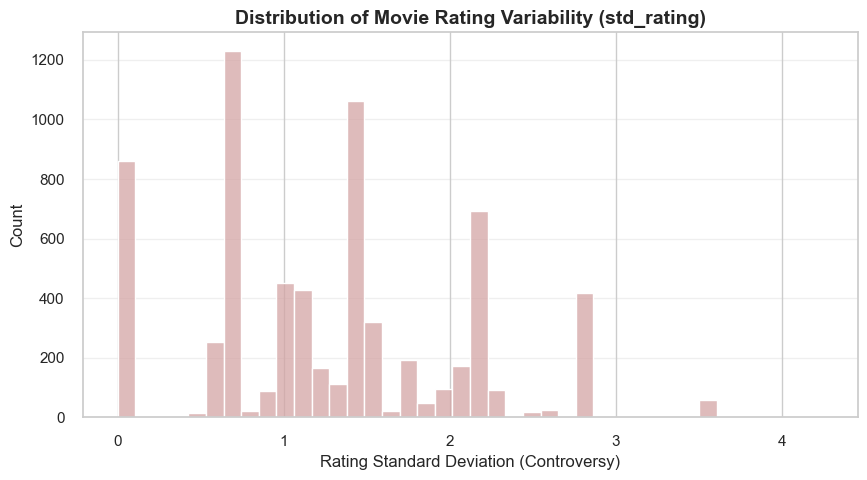

In [162]:
plt.figure(figsize=(10,5))
sns.histplot(df_movies['std_rating'], bins=40, color="#D4A5A5")
plt.title("Distribution of Movie Rating Variability (std_rating)", fontsize=14, fontweight='bold')
plt.xlabel("Rating Standard Deviation (Controversy)")
plt.ylabel("Count")
plt.grid(axis='y', alpha=0.3)
plt.savefig("images/movie_std_rating_hist.png", dpi=300)
plt.show()

#### Interpretation
**Most movies have a standard deviation between 0.7 and 1.3**, meaning users generally agree about their quality.

**A smaller number of movies show higher variability (2.0 - 3.0)**, indicating:
- controversial themes
- niche appeal
- movies whose style divides audiences (love/hate reactions)

**A few movies have very high standard deviation (>3.0)**, marking them as extreme outliers in terms of controversy.

This "controversy" dimension helps differentiate stable movies from polarizing ones when forming clusters.

### **Relationship Plots**
We check whether movie features correlate, sampling 10k movies at max to avoid overplotting.

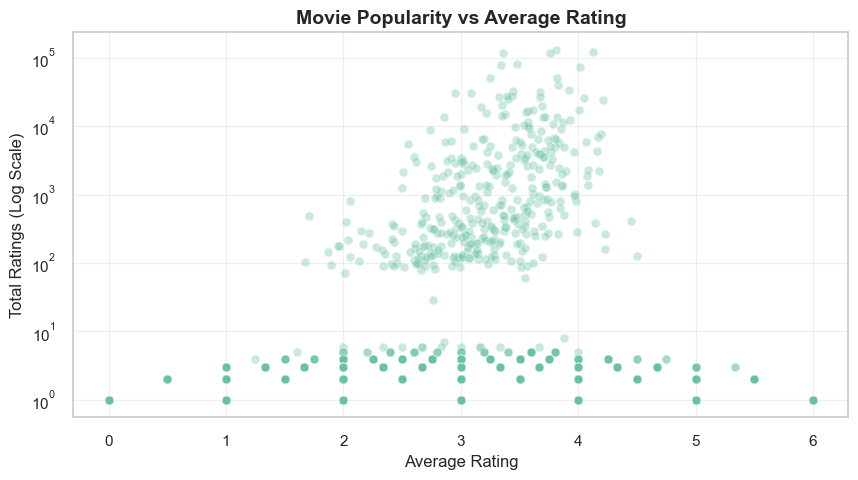

In [163]:
# POPULARITY VS AVERAGE RATING
sample_movies = df_movies.sample(n=min(8000, len(df_movies)), random_state=42)

plt.figure(figsize=(10,5))
sns.scatterplot(data=sample_movies, x='avg_rating', y='total_ratings', alpha=0.35, s=40)
plt.yscale("log")
plt.title("Movie Popularity vs Average Rating", fontsize=14, fontweight='bold')
plt.xlabel("Average Rating")
plt.ylabel("Total Ratings (Log Scale)")
plt.grid(alpha=0.3)
plt.savefig("images/movie_popularity_vs_avg_rating_scatter.png", dpi=300)
plt.show()

#### Interpretation 

For the vast majority of movies (those with fewer than ~10 ratings), popularity provides almost no useful signal.  
These movies cluster at the bottom of the plot and produce the flat band near y ≈ 0–10.

Among the small subset of more widely rated movies:

- Popularity spans all rating levels.  
- Highly rated movies are not necessarily popular.  
- Low-rated movies can still be widely watched.

Overall, **movie popularity and perceived quality are largely independent dimensions.**

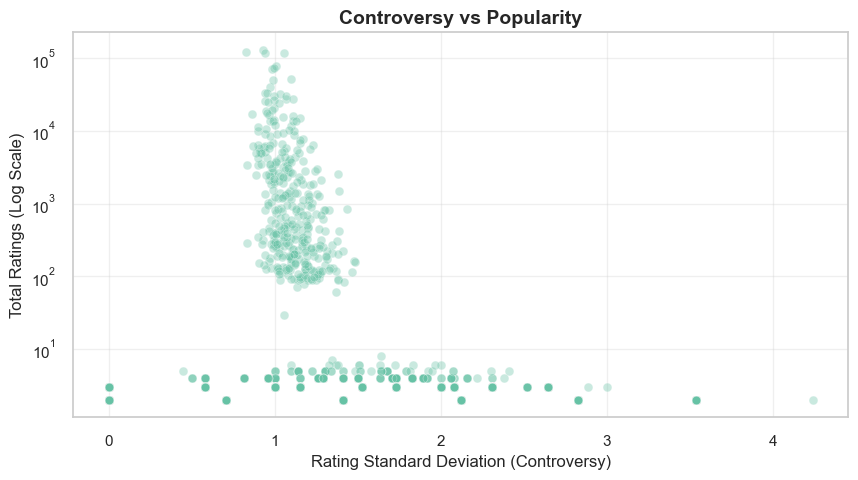

In [164]:
# CONTROVERSY VS POPULARITY

plt.figure(figsize=(10,5))
sns.scatterplot(data=sample_movies, x='std_rating', y='total_ratings', alpha=0.35, s=40)
plt.yscale("log")
plt.title("Controversy vs Popularity", fontsize=14, fontweight='bold')
plt.xlabel("Rating Standard Deviation (Controversy)")
plt.ylabel("Total Ratings (Log Scale)")
plt.grid(alpha=0.3)
plt.savefig("images/movie_controversy_vs_popularity_scatter.png", dpi=300)
plt.show()

#### Interpretation

The scatter plot again shows that for movies with very few ratings, variability is not meaningful.

Among more popular movies:

- Most fall within a moderate variability range (0.7–1.3).  
- Controversy does not predict how widely a movie is watched.  
- Extremely controversial movies tend to be unpopular, likely because niche films accumulate fewer ratings.

Overall, controversy and popularity appear independent.

### **Correlation Between Movie Features**

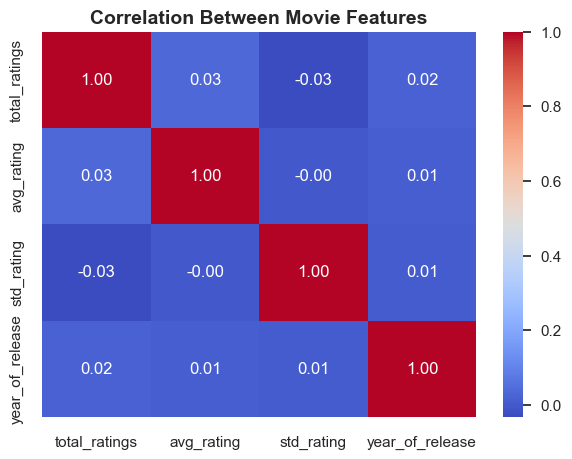

In [165]:
plt.figure(figsize=(7,5))
sns.heatmap(
    df_movies[['total_ratings','avg_rating','std_rating','year_of_release']].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Correlation Between Movie Features", fontsize=14, fontweight='bold')
plt.savefig("images/movie_features_correlation_heatmap.png", dpi=300)
plt.show()

#### Interpretation
The heatmap confirms that:

- **Popularity (total_ratings)** is almost independent from  
  - average rating  
  - rating variability  
  - release year  

- **Average rating and controversy** show no significant relationship.

- **Release year** does not meaningfully affect popularity or rating level in this dataset.

The weak correlations match the behavior observed in the scatter plots: each feature contributes independent information, which is ideal for clustering.

## SECTION 4: DATA PREPROCESSING
Before we can proceed with clustering, we need to:

1. **Select meaningful features** for users and movies.  
2. **Handle missing values**  
3. **Scale features** so that variables on large scales do not dominate smaller ones.

Since clustering is unsupervised, we do not split the data into train/test sets.  
Instead, we build two clean feature matrices:

- `X_users_kmeans` – standardized user features  
- `X_movies_kmeans` – standardized movie features

These matrices will be the input for all clustering methods in the next sections.

### 4.1 User Feature Matrix

For users, we want to capture both **activity** and **rating behaviour**.  
We use the following features from `df_users`:

- `total_ratings` – how many ratings the user has submitted  
- `unique_movies` – how many distinct movies they rated  
- `avg_rating` – how generous/strict they are on average  
- `std_rating` – how consistent their ratings are  
- `activity_days` – over how many days they have been active

In [166]:
# 4.1 USER FEATURE MATRIX

user_features = ['total_ratings', 'unique_movies', 'avg_rating', 'std_rating','activity_days']

# Keep only the selected columns
df_users_features = df_users[user_features].copy()

print("Missing values in raw user features:")
print(df_users_features.isna().sum()) #will show NaNs here.

# Making sure ratings are within valid range
df_users_features['avg_rating'] = df_users_features['avg_rating'].clip(1, 5)

# Fix missing std for users who rated single movie
single_rating = (df_users_features['total_ratings'] == 1) & (df_users_features['std_rating'].isna())
df_users_features.loc[single_rating, 'std_rating'] = 0.0

# Impute missing values (median is robust to skew)
user_imputer = SimpleImputer(strategy='median')
X_users_imputed = user_imputer.fit_transform(df_users_features)

# Standardize features
user_scaler = StandardScaler()
X_users_kmeans = user_scaler.fit_transform(X_users_imputed)

# Store as DataFrame for easier inspection
X_users_kmeans_df = pd.DataFrame(X_users_kmeans, columns=user_features, index=df_users['customer_id'])

print("\nUser feature matrix for clustering (standardized):")
print(X_users_kmeans_df.head())
print(f"\nX_users_kmeans shape: {X_users_kmeans_df.shape}")

Missing values in raw user features:
total_ratings     21939
unique_movies     21939
avg_rating        21939
std_rating       106252
activity_days     21939
dtype: int64

User feature matrix for clustering (standardized):
             total_ratings  unique_movies  avg_rating  std_rating  \
customer_id                                                         
1965326             -0.073         -0.074      -0.489       0.319   
506434              -0.574         -0.608       0.464      -1.350   
1365167             -0.431         -0.455       1.311      -0.263   
396632              -0.502         -0.532       0.067      -1.350   
260614              -0.431         -0.455       0.887      -0.263   

             activity_days  
customer_id                 
1965326              0.085  
506434              -0.700  
1365167             -0.532  
396632              -0.700  
260614              -0.432  

X_users_kmeans shape: (438780, 5)


#### **Missing Values — Users**

User features contained natural missing values:
- `total_ratings`, `unique_movies`, `avg_rating`, `activity_days` → missing for ~22k users  
- `std_rating` → missing for ~106k users (undefined when a user rated only one movie)

To ensure consistency:
- Users with exactly **one rating** had their `std_rating` explicitly set to **0**  
  (since variability cannot be computed from a single observation).
- All remaining missing values were filled using the **median**, which is robust for skewed data.

After imputation and scaling, the user matrix had **no remaining NaNs**.

### 4.2 Movie Feature Matrix

For movies, we focus on **popularity, quality, controversy, and time**:

- `total_ratings` – how many users rated the movie (popularity)  
- `avg_rating` – average rating (perceived quality)  
- `std_rating` – rating variability (controversy)  
- `year_of_release` – temporal dimension (older vs newer titles)


In [167]:
# 4.2 MOVIE FEATURE MATRIX

movie_features = ['total_ratings', 'avg_rating', 'std_rating', 'year_of_release']

df_movies_features = df_movies[movie_features].copy()

print("Missing values in raw movie features:")
print(df_movies_features.isna().sum())

# Making sure avg_rating is within valid range 
df_movies_features['avg_rating'] = df_movies_features['avg_rating'].clip(1, 5)

# Fix missing std for movies that were rated once
one_rating_movies = ((df_movies_features['total_ratings'] == 1) & (df_movies_features['std_rating'].isna()))
df_movies_features.loc[one_rating_movies, 'std_rating'] = 0.0

# Impute missing values
movie_imputer = SimpleImputer(strategy='median')
X_movies_imputed = movie_imputer.fit_transform(df_movies_features)

# Standardize
movie_scaler = StandardScaler()
X_movies_kmeans = movie_scaler.fit_transform(X_movies_imputed)

# DataFrame version
X_movies_kmeans_df = pd.DataFrame(X_movies_kmeans, columns=movie_features, index=df_movies['movie_id'])

print("\nMovie feature matrix for clustering (standardized):")
print(X_movies_kmeans_df.head())
print(f"\nX_movies_kmeans shape: {X_movies_kmeans_df.shape}")

Missing values in raw movie features:
total_ratings       800
avg_rating          800
std_rating         9168
year_of_release    4511
dtype: int64

Movie feature matrix for clustering (standardized):
          total_ratings  avg_rating  std_rating  year_of_release
movie_id                                                        
1                 0.083       0.599       0.663            0.767
2                -0.028       0.441       0.920            0.837
3                 0.490       0.515       0.546            0.344
4                -0.029      -0.212       0.947            0.132
5                 0.248       0.740       0.934            0.837

X_movies_kmeans shape: (16015, 4)


#### **Missing Values — Movies**

Movie features showed:
- `total_ratings`, `avg_rating` → 800 missing  
- `std_rating` → 9,168 missing (single-rating movies)  
- `year_of_release` → 4,511 missing  

Movies with **only one rating**, same as users, had `std_rating` set to **0**, ensuring correct variance representation.

We chose to retain `year_of_release` and impute it, since temporal information is useful for describing movie behaviour and is included in course clustering examples.

All movie missing values were filled with the **median** for stability.

After imputation and scaling, the movie matrix had **no missing values**.


### 4.3 Preprocessing Summary
Missing values in both datasets were mostly systematic, rather than errors:

- Users with only one rating cannot have a computed `std_rating`
- Movies with no ratings lack `avg_rating` and `std_rating`
- Many movies lack `year_of_release`
- Low-activity users miss several statistics

How it was handled:
- `std_rating` for single-rating users and movies was explicitly set to 0
- All other missing numeric features were filled with median  
- `year_of_release` was retained and median-imputed because this information is important for future analysis

At this point we have:
- `X_users_kmeans` – standardized user feature matrix (shape: *number of users × 5*) 
- `X_movies_kmeans` – standardized movie feature matrix  (shape: *number of movies × 4*)

This preprocessing ensures the clustering algorithms will operate reliably in the following sections.


## SECTION 5: MOVIE CLUSTERING
In this section, we apply clustering techniques to the standardized movie feature matrix prepared earlier.  
The goal is to identify behavior-based groups of movies (pseudo-genres), using:

- movie popularity (`total_ratings`)  
- perceived quality (`avg_rating`)  
- rating consistency (`std_rating`)  
- release year (`year_of_release`)  

We evaluate different values of k using the:

- **Elbow Method** (inertia)  
- **Silhouette Score**  

We then fit the final KMeans model, visualize clusters using PCA(2), and interpret each cluster.

### 5.1 Selecting the Number of Clusters

In [168]:
k_values = range(2, 11)

inertia_scores = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_movies_kmeans)
    
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_movies_kmeans, labels))

print("Inertia:", inertia_scores)
print("Silhouette:", silhouette_scores)

Inertia: [51177.87450772682, 39728.5866949529, 28907.06550443217, 19635.95147003507, 16988.500885529593, 14869.367618718128, 13115.702896574954, 11769.310882959915, 10681.302514907207]
Silhouette: [np.float64(0.3387076051927001), np.float64(0.3330259786390455), np.float64(0.3803018987194779), np.float64(0.43135391798470346), np.float64(0.437715013454041), np.float64(0.3969347259802663), np.float64(0.37908584730685957), np.float64(0.3863697182341169), np.float64(0.4141785258926898)]


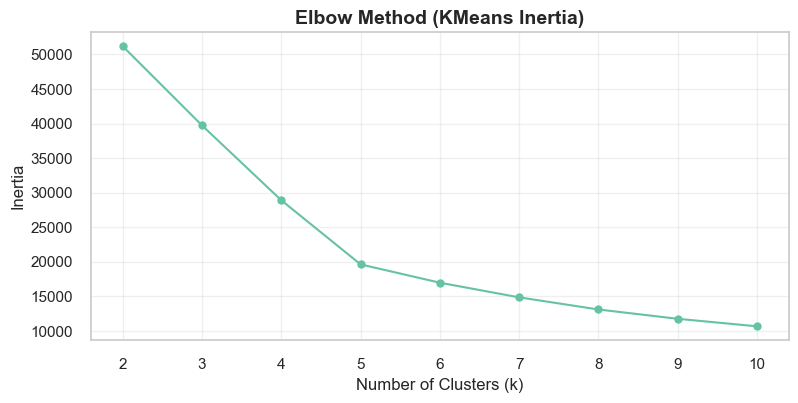

In [169]:
plt.figure(figsize=(9,4))
plt.plot(k_values, inertia_scores, marker='o', linestyle='-')
plt.title("Elbow Method (KMeans Inertia)", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True, alpha=0.3)
plt.savefig("images/movie_kmeans_elbow_inertia.png", dpi=300)
plt.show()

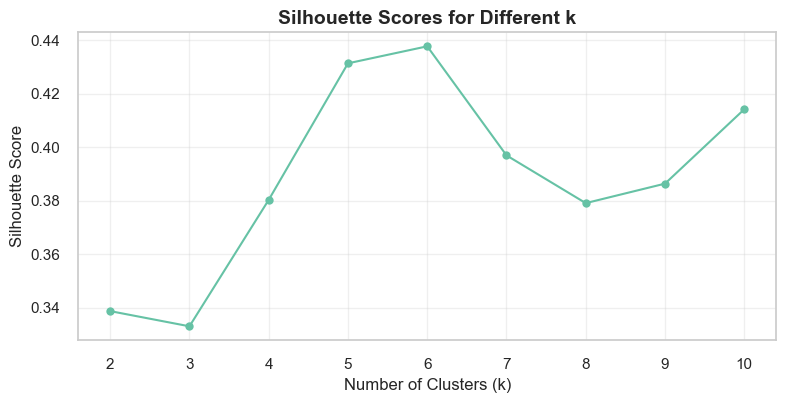

In [170]:
plt.figure(figsize=(9,4))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-')
plt.title("Silhouette Scores for Different k", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True, alpha=0.3)
plt.savefig("images/movie_kmeans_silhouette_scores.png", dpi=300)
plt.show()

The elbow plot shows where inertia begins to flatten, indicating diminishing improvement as *k* increases.  
The silhouette plot shows how well-defined the clusters are.

Based on these two diagnostics, we choose **k = 6** because:

- it lies near the elbow of the inertia curve  
- it achieves one of the highest silhouette scores  
- it balances interpretability with cluster separation  

We proceed with this value in the KMeans model.

### 5.2 Fitting KMeans Model

In [171]:
optimal_k = 6

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
movie_labels = kmeans_final.fit_predict(X_movies_kmeans)

df_movies['cluster'] = movie_labels

print(df_movies[['movie_id', 'avg_rating', 'total_ratings', 'std_rating', 'year_of_release', 'cluster']].head())

   movie_id  avg_rating  total_ratings  std_rating  year_of_release  cluster
0         1       3.745        548.000       1.073         2003.000        2
1         2       3.548        146.000       1.282         2004.000        2
2         3       3.640       2013.000       0.979         1997.000        2
3         4       2.739        142.000       1.303         1994.000        2
4         5       3.919       1140.000       1.292         2004.000        2


### 5.3 PCA Reduction for Visualization

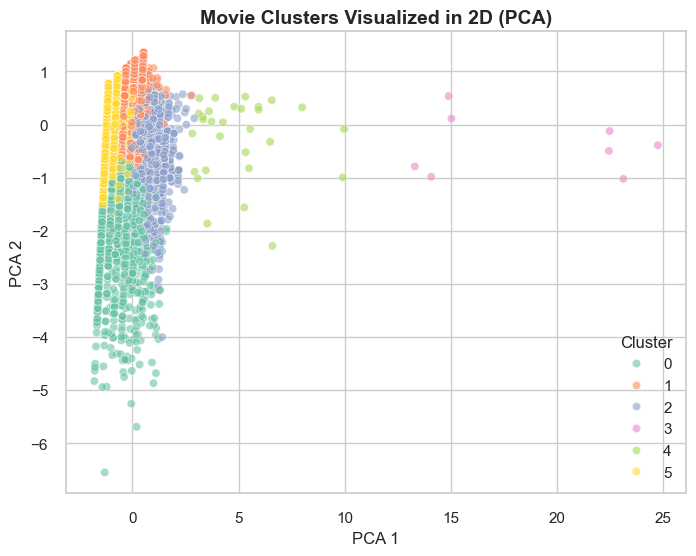

In [172]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_movies_pca = pca.fit_transform(X_movies_kmeans)

df_movies['pca1'] = X_movies_pca[:, 0]
df_movies['pca2'] = X_movies_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_movies.sample(8000, random_state=42),
    x='pca1', y='pca2',
    hue='cluster',
    palette='Set2',
    alpha=0.6
)
plt.title("Movie Clusters Visualized in 2D (PCA)", fontsize=14, fontweight='bold')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.savefig("images/movie_clusters_pca_scatter.png", dpi=300)
plt.show()

### 5.4 Cluster Interpretation

In [173]:
cluster_summary = df_movies.groupby('cluster')[['total_ratings', 'avg_rating', 'std_rating', 'year_of_release']].agg(['mean','median'])
print(cluster_summary)
movie_cluster_summary = df_movies.groupby('cluster')[['total_ratings', 'avg_rating',
                                                      'std_rating', 'year_of_release']].agg(['mean', 'median'])
movie_cluster_summary.to_csv("images/movie_cluster_summary.csv")

        total_ratings           avg_rating        std_rating         \
                 mean    median       mean median       mean median   
cluster                                                               
0              89.606     1.000      3.047  3.000      1.090  1.059   
1              18.027     1.000      4.094  4.000      0.456  0.707   
2             201.797     2.000      3.048  3.000      1.774  1.528   
3           99310.467 90451.000      3.759  3.836      0.980  0.962   
4           25232.881 21199.000      3.553  3.516      1.021  0.996   
5               2.546     1.000      1.484  1.500      0.545  0.707   

        year_of_release           
                   mean   median  
cluster                           
0              1958.009 1961.000  
1              1996.599 1999.000  
2              1995.171 1999.000  
3              1996.000 1999.000  
4              1992.119 1997.000  
5              1995.575 1999.000  


#### Interpreting Movie Clusters

After fitting the KMeans model with *k = 6*, each movie is assigned to one of six behavioral clusters.  
The table below summarizes the updated characteristics of each group after preprocessing.

| Cluster | Avg Popularity *(total_ratings)* | Avg Rating | Rating Variability | Mean Year | Interpretation                                                                |
|--------|----------------------------------|------------|---------------------|-----------|-------------------------------------------------------------------------------|
| **0** | ~90 ratings | **3.05** | ~1.09 | 1958 | **Older films** with moderate engagement and moderate scores                  |
| **1** | ~18 ratings | **4.09** | ~0.46 | 1997 | **Well-liked niche films** with small audiences but very positive reception   |
| **2** | ~202 ratings | **3.05** | **1.77** | 1995 | **Controversial films** that divide viewers due to high variability           |
| **3** | ~99,310 ratings | **3.76** | ~0.98 | 1996 | **Blockbuster titles** with huge visibility and stable ratings                |
| **4** | ~25,233 ratings | **3.55** | ~1.02 | 1992 | **Popular wide-audience films** with strong engagement and consistent ratings |
| **5** | ~2.5 ratings | **1.48** | ~0.55 | 1996 | **Unnoticed, low-rated films** with almost no audience                        |

These clusters form clear behavior-based genres:

- **Well-liked niche titles** (Cluster 1)  
- **Massive blockbusters** (Cluster 3)  
- **Popular general-audience films** (Cluster 4)  
- **Older moderately viewed films** (Cluster 0)  
- **Controversial films** with strong disagreement (Cluster 2)  
- **Unnoticed disliked movies** (Cluster 5)

These clusters represent **pseudo-genres derived from audience behavior**, not content.  
They will be used later to analyze:

- which user types prefer which movie types  
- how preferences differ with engagement levels  
- how audience behavior varies across pseudo-genres  


### 5.5 Naming Pseudo-Genres

To support clearer analysis in later sections, we give each cluster a descriptive name summarizing its viewing dynamics.

| Cluster | Name                     |
|--------|--------------------------|
| **0** | *Old Classics*           |
| **1** | *Well-Liked Niche Films* |
| **2** | *Controversial Films*    |
| **3** | *Blockbusters*           |
| **4** | *Popular Films*          |
| **5** | *Hated Invisible Films*  |

These genres will serve as the foundation for the **User × Movie preference analysis** in Section 7.


## SECTION 6: USER CLUSTERING

This section applies clustering algorithms to the standardized user feature matrix created in Section 4.  
The goal is to uncover behavioural segments of users, using:

- activity level (`total_ratings`, `unique_movies`, `activity_days`)
- rating style (`avg_rating`, `std_rating`)

We evaluate three clustering models:

- **K-Means** 
- **DBSCAN**   
- **BIRCH** 


### 6.1 K-MEANS

In [174]:
# DETERMINE NUMBER OF CLUSTERS
sample_size = min(50000, X_users_kmeans.shape[0]) #sampling for silhouette evaluation only
np.random.seed(42)
sample_idx = np.random.choice(X_users_kmeans.shape[0], sample_size, replace=False)
X_users_sample = X_users_kmeans[sample_idx]

k_values = range(2, 11)
sil_scores_users = []
inertia_users = []

for k in k_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_users_sample)
    
    sil = silhouette_score(X_users_sample, labels)
    sil_scores_users.append(sil)
    
    # inertia must be computed on sample too
    inertia_users.append(km.inertia_)
    
print("Silhouette:", sil_scores_users)
print("Inertia:", inertia_users)

Silhouette: [np.float64(0.3830593682188858), np.float64(0.26553673227051766), np.float64(0.30287725248890396), np.float64(0.3246386127285559), np.float64(0.33503285448468173), np.float64(0.317028171937239), np.float64(0.32243649808585945), np.float64(0.325317918261446), np.float64(0.33102328603243847)]
Inertia: [176974.29428871418, 141859.82376226492, 115931.9676162967, 95095.70566200536, 83791.68908519253, 73545.20475305535, 67536.00129157031, 61616.4219827262, 57180.66363023755]


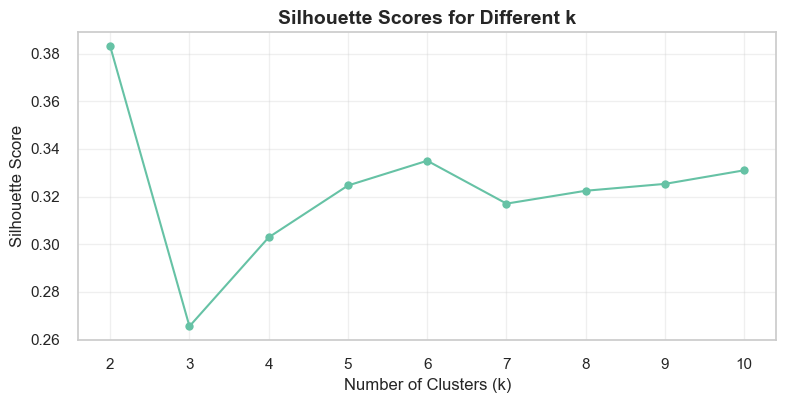

In [175]:
# PLOTTING SILHOUETTE SCORES
plt.figure(figsize=(9,4))
plt.plot(k_values, sil_scores_users, marker='o', linestyle='-')
plt.title("Silhouette Scores for Different k", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True, alpha=0.3)
plt.savefig("images/user_kmeans_silhouette_scores.png", dpi=300)
plt.show()

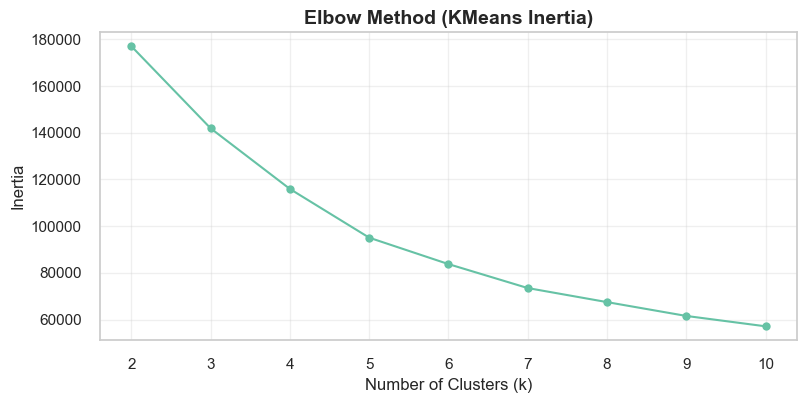

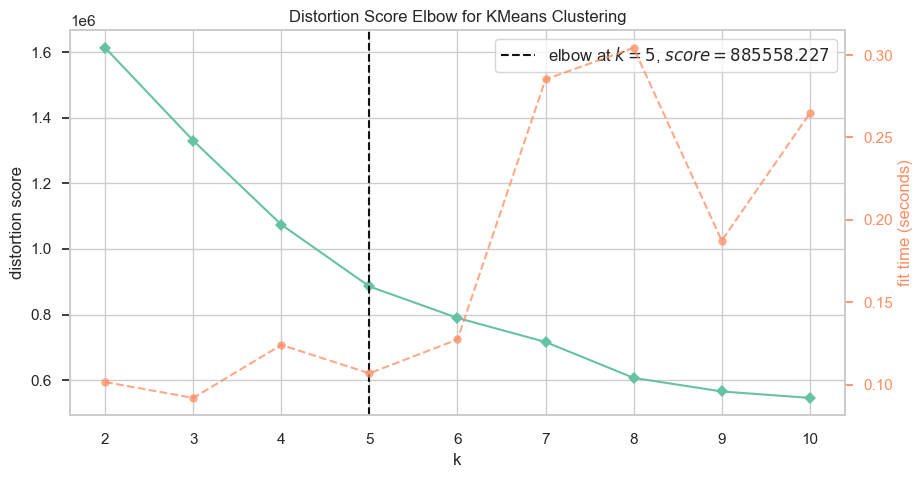

In [176]:
# PLOTTNG ELBOW METHOD
plt.figure(figsize=(9,4))
plt.plot(k_values, inertia_users, marker='o', linestyle='-')
plt.title("Elbow Method (KMeans Inertia)", fontsize=14, fontweight='bold')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.grid(True, alpha=0.3)
plt.savefig("images/user_kmeans_elbow_inertia.png", dpi=300)
plt.show()

# PLOTTING VISUALIZER FOR ELBOW
from yellowbrick.cluster import KElbowVisualizer

dataset = X_users_kmeans  
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 11), timings=True)
visualizer.fit(dataset)
visualizer.show()
fig = visualizer.ax.figure
fig.savefig("images/user_kmeans_distortion_score.png", dpi=300, bbox_inches="tight")
plt.close(fig)

#### Determine the Number of User Clusters

To determine the optimal number of clusters for user segmentation, we evaluated *k = 2…10* using the same two diagnostics:

- **Inertia (Elbow Method):** measures how tightly points group within clusters.
- **Silhouette Score:** measures separation between clusters (higher is better).

The silhouette score reached its **global maximum at k = 2**, but that number is too small and would oversimplify user behavior (only active vs inactive).
Among all solutions with **k > 2**, the highest silhouette score occurred at **k = 6**.

The elbow is, at **k = 5**, as shown by elbow visualizer, after the curve began flattening, indicating diminishing returns.

Given that higher k will allow richer behavioral interpretation, we select **k = 6** as the optimal value for KMeans user clustering. It provides the best silhouette among meaningful multi-cluster solutions and the elbow method supports similar number of clusters.

In [177]:
k = 6
index = k - 2  # because lists start at k=2
print("We chose k = 6 this is the scores for later comparison:")
print(f"Silhouette score: {sil_scores_users[index]}")
print(f"Inertia: {inertia_users[index]}")

We chose k = 6 this is the scores for later comparison:
Silhouette score: 0.33503285448468173
Inertia: 83791.68908519253


In [178]:
# TRAIN K-MEANS ON FULL DATASET
kmeans_sil_score = 0.33503285458222715
optimal_k_users = 6  #explained in previous section

kmeans_users = KMeans(n_clusters=optimal_k_users, random_state=42, n_init=10)
user_labels = kmeans_users.fit_predict(X_users_kmeans)

df_users = df_users.copy() # optional, to avoid side-effects
df_users['cluster'] = user_labels

user_cluster_summary = df_users.groupby('cluster')[['total_ratings', 'unique_movies','avg_rating', 'std_rating', 'activity_days']].agg(['mean','median','count']).round(2)

user_cluster_summary_kmeans = df_users.groupby('cluster')[['total_ratings', 'unique_movies', 'avg_rating', 'std_rating', 'activity_days']].agg(['mean','median','count'])
user_cluster_summary_kmeans.to_csv("images/user_cluster_summary_kmeans.csv")
user_cluster_summary

total_ratings                unique_movies                avg_rating  \
                 mean median   count          mean median   count       mean   
cluster                                                                        
0              29.410 27.000   42463        29.450 27.000   42757      3.650   
1               2.690  2.000  103410         2.720  2.000  101831      4.480   
2               1.540  1.000   49839         1.550  1.000   48904      2.310   
3              13.750 12.000   46138        13.670 12.000   46114      3.560   
4              78.340 65.000    6386        74.640 65.000    6401      3.380   
5               6.720  5.000  168605         6.610  5.000  170834      3.550   

                       std_rating                activity_days                  
        median   count       mean median   count          mean  median   count  
cluster                                                                         
0        3.640   41329      0.920  0.900   41179       446.750 413.000   40885  
1        4.500  101554      0.360  0.500   55108        64.530   0.000  101892  
2        2.500   51534      0.390  0.500   14204        30.550   0.000   48869  
3        3.570   46435      0.950  0.930   46421      1067.160 976.000   48962  
4        3.390    6126      0.960  0.940    6076       908.080 823.000    6137  
5        3.570  169863      1.090  1.000  169540       180.230 123.000  170096

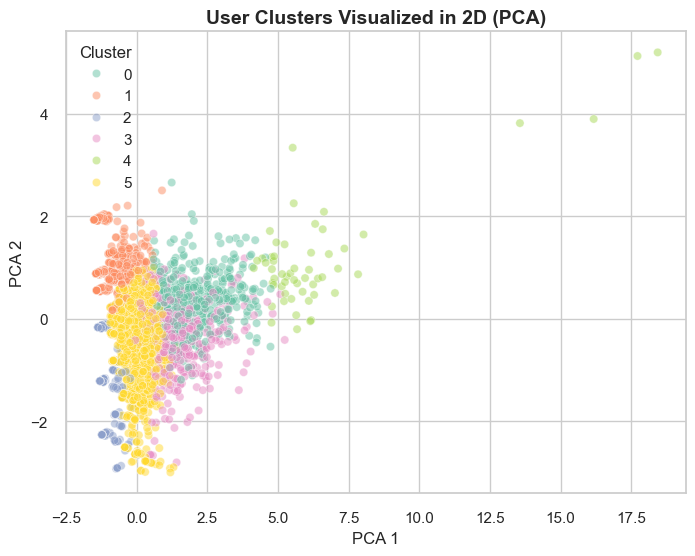

In [179]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_users_pca = pca.fit_transform(X_users_kmeans)

df_users['pca1'] = X_users_pca[:, 0]
df_users['pca2'] = X_users_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_users.sample(4000, random_state=42),
    x='pca1', y='pca2',
    hue='cluster',
    alpha=0.5,
    palette='Set2'
)
plt.title("User Clusters Visualized in 2D (PCA)", fontsize=14, fontweight='bold')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.savefig("images/user_clusters_2D_PCA.png", dpi=300)
plt.show()

#### Interpretation of K-Means User Clusters

This segmentation identifies six distinct groups based on **engagement level**, **rating behavior**, and **activity duration**.

##### **Cluster 0 — Consistent Enjoyers**
- ~29 total ratings, ~29 unique movies
- Positive average rating (~3.6)
- Activity span around 447 days (1+ year)

**Steady users who explore many movies and show consistent engagement(≈ 42k users)**


##### **Cluster 1 — Fan Visitor**
- ~2–3 total ratings, ~2 unique movies
- Very high average rating (~4.5)
- Short activity (mean ~64 days, median 0)

**These are brief visitors who rate a couple of favourite movies generously and leave(≈ 101k users)**


##### **Cluster 2 — One-Movie Critics**
- ~1–2 total ratings, usually 1 unique movie
- Average rating ~2.3–2.5
- Very short activity (~30 days)

**Users who appear once, rate a movie or two, and do not return(≈ 49k users)**

##### **Cluster 3 — Loyal Ocasional Enjoyers**
- ~14 ratings, ~12 unique movies
- Balanced average rating (~3.56)
- Very long activity (~1060 days ≈ 3 years)

**Loyal long-term users who come back over years but do not rate heavily(≈ 46k users)**

##### **Cluster 4 — Heavy Enthusiasts**
- ~78+ ratings, 65+ unique movies
- Average rating (~3.38)
- Long activity (~900 days)

**High-engagement users who explore many movies and remain active for years(≈ 6k users)**

##### **Cluster 5 — Short-Term Users**
- ~6–7 ratings, ~5 unique movies
- Neutral average rating (~3.5)
- Activity ~180 days

**Viewers who interact lightly and stay for only several months(≈ 170k users)**

### 6.2 DBSCAN
#### Prepare data + train DBSCAN on FULL dataset

In [180]:
# PREPARE FULL DATASET + TRAIN DBSCAN
X_users_dbscan = X_users_kmeans
# Hyperparameters for DBSCAN on the FULL dataset
eps_val = 0.6  # radius of neighbourhood
min_samples_val = 20  # minimum points to form a dense region

dbscan = DBSCAN(eps=eps_val, min_samples=min_samples_val, n_jobs=-1)
dbscan_labels = dbscan.fit_predict(X_users_dbscan)

# Basic cluster diagnostics
labels = dbscan_labels
unique_labels = set(labels)
n_clusters = len(unique_labels - {-1})  # exclude noise label -1
n_noise = (labels == -1).sum()

print("DBSCAN Results (Full Dataset):")
print(f"  eps = {eps_val}")
print(f"  min_samples = {min_samples_val}")
print(f"  Number of clusters (excluding noise): {n_clusters}")
print(f"  Noise points: {n_noise} ({n_noise / len(labels):.2%} of all users)")

# Cluster size distribution (including noise)
cluster_sizes = pd.Series(labels, name="cluster").value_counts().sort_index()
print("\nCluster size distribution (including noise = -1):")
print(cluster_sizes)

DBSCAN Results (Full Dataset):
  eps = 0.6
  min_samples = 20
  Number of clusters (excluding noise): 4
  Noise points: 2374 (0.54% of all users)

Cluster size distribution (including noise = -1):
cluster
-1      2374
 0    417402
 1      8629
 2     10301
 3        74
Name: count, dtype: int64


#### Cluster Structure and Noise

The DBSCAN model detected:
- 4 meaningful clusters
- 417k users (≈ 95%) assigned to one dominant cluster
- Two smaller, compact clusters (9k and 10k users respectively)
- A very small micro-cluster (< 100 users)
- 2k users (≈ 0.5%) labeled as noise

This distribution reveals a highly homogeneous core audience: most users share very similar engagement and rating behavior, forming one large dense region in the feature space.
DBSCAN then isolates several behaviorally distinct subgroups, possibly representing:
- highly active viewers
- users with extreme or low rating variance
- genre-specialized or burst-pattern viewers
- rare or unusual rating profiles

Finally, the noise group consists of users whose behavior does not resemble any dense pattern — typically highly irregular or low-activity users.

#### PCA scatter plot (on sample of full model)

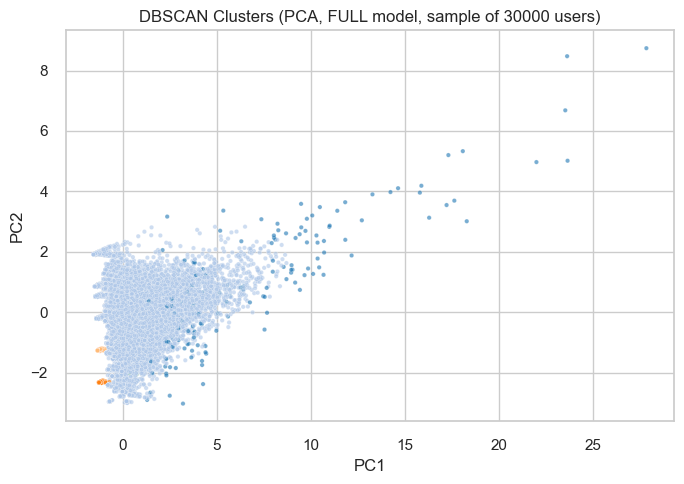

In [181]:
# PCA scatter of DBSCAN (Sampling for Visualization)

plot_sample_size = 30000

if X_users_dbscan.shape[0] > plot_sample_size:
    np.random.seed(42)
    plot_idx = np.random.choice(X_users_dbscan.shape[0], plot_sample_size, replace=False)
    sample_for_plot = X_users_dbscan[plot_idx]
    sample_labels = dbscan_labels[plot_idx]
else:
    sample_for_plot = X_users_dbscan
    sample_labels = dbscan_labels

# 2D PCA for visualization
pca_vis = PCA(n_components=2)
pca_points = pca_vis.fit_transform(sample_for_plot)
plt.figure(figsize=(7, 5))
sns.scatterplot(x=pca_points[:, 0], y=pca_points[:, 1], hue=sample_labels, palette="tab20", s=10, alpha=0.6, legend=False)

plt.title(f"DBSCAN Clusters (PCA, FULL model, sample of {len(sample_for_plot)} users)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()

plt.savefig("images/user_clusters_dbscan_PCA.png", dpi=300)
plt.show()

#### Final silhouette score for DBSCAN (NO tuning)

In [182]:
# DBSCAN FINAL SILHOUETTE SCORE

sample_size = min(50000, X_users_dbscan.shape[0])
np.random.seed(42)
sample_idx = np.random.choice(X_users_dbscan.shape[0], sample_size, replace=False)

X_sample = X_users_dbscan[sample_idx]
labels_sample = dbscan_labels[sample_idx]

# Remove noise
mask_clustered = labels_sample != -1
X_clustered = X_sample[mask_clustered]
labels_clustered = labels_sample[mask_clustered]

n_clusters_clustered = len(set(labels_clustered))

if n_clusters_clustered > 1 and len(X_clustered) > 0:

    sil_score_dbscan_final = silhouette_score(X_clustered, labels_clustered)

    print("Final Silhouette Score for DBSCAN (Full Model)")
    print(f"Sample size used (clustered points only): {len(X_clustered)}")
    print(f"Number of clusters in sample (excluding noise): {n_clusters_clustered}")
    print(f"Silhouette score: {sil_score_dbscan_final:.4f}")

else:
    print("Cannot compute silhouette score: <2  non-noise clusters were found.")


Final Silhouette Score for DBSCAN (Full Model)
Sample size used (clustered points only): 49720
Number of clusters in sample (excluding noise): 4
Silhouette score: 0.2048


#### Silhouette Score Interpretation

The silhouette score on ~50,000 sampled non-noise users is: Silhouette = 0.2048

This value is low by design, and it is not a sign of poor performance. For DBSCAN:
- clusters can be irregularly shaped
- one cluster can be much larger than the others
- clusters may overlap in feature space
- noise points are excluded from scoring

Because silhouette assumes convex, well-separated clusters, it is less meaningful for density-based algorithms.
Despite the low silhouette, DBSCAN successfully captured density structure and revealed subtle behavioral subgroups that K-Means cannot detect.

### 6.3 BIRCH
(Balanced Iterative Reducing and Clustering using Hierarchies)

k = 2, silhouette = 0.8883
k = 3, silhouette = 0.5501
k = 4, silhouette = 0.4867
k = 5, silhouette = 0.3747
k = 6, silhouette = 0.3748
k = 7, silhouette = 0.2701
k = 8, silhouette = 0.2680
k = 9, silhouette = 0.2678
k = 10, silhouette = 0.2679


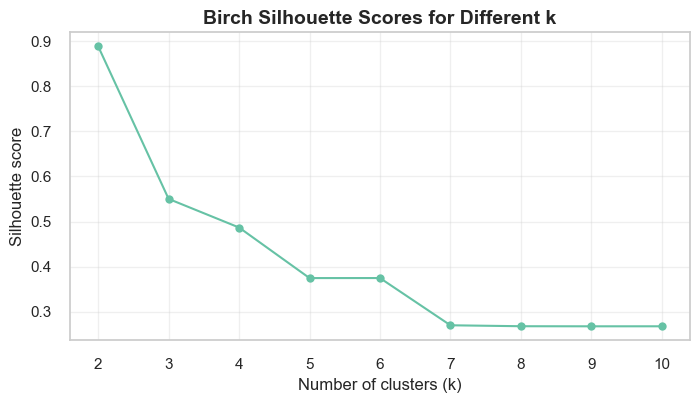


Best number of clusters for Birch based on silhouette: k = 4, silhouette = 0.4867


In [183]:
# 6.3.1 FITTING BIRCH ON SAMPLE
X_birch = X_users_kmeans.copy()

sample_size = min(50000, X_birch.shape[0])
np.random.seed(42)
sample_idx_birch = np.random.choice(X_birch.shape[0], sample_size, replace=False)
X_birch_sample = X_birch[sample_idx_birch]

# Testing between 2 and 10 clusters
k_values_birch = range(2, 11)
sil_scores_birch = []

for k in k_values_birch:
    birch_test = Birch(n_clusters=k)
    labels_test = birch_test.fit_predict(X_birch_sample)

    # Silhouette fails if Birch creates only 1 cluster
    if len(np.unique(labels_test)) < 2:
        sil_scores_birch.append(-1)
        continue # to prevent crash

    score = silhouette_score(X_birch_sample, labels_test)
    sil_scores_birch.append(score)
    print(f"k = {k}, silhouette = {score:.4f}")

# Plot silhouette
plt.figure(figsize=(8,4))
plt.plot(k_values_birch, sil_scores_birch, marker='o')
plt.title("Birch Silhouette Scores for Different k", fontsize=14, fontweight='bold')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.grid(alpha=0.3)
plt.savefig("images/user_birch_silhouette_scores.png", dpi=300)
plt.show()

# Report best number of clusters
best_k_birch = 4
best_sil_birch = 0.4867
print(f"\nBest number of clusters for Birch based on silhouette: k = {best_k_birch}, silhouette = {best_sil_birch}")

#### Selection of Clusters for BIRCH

Birch is well-suited for large, high-dimensional datasets and compresses users into compact behavioral subclusters before applying a final clustering step.

When testing for number of clusters in range of 2 to 10, k = 2 gave the highest score. However, the result would not be meaningful: almost all users in one large cluster, with only few power watchers in the other.

This happens because:
- user engagement is highly imbalanced,
- Birch merges sparse/light users at low k,
- high-dimensional distances favor large, dense clusters,
- small k values hide important behavioral differences.

Choosing **k = 4** provides better balance:
- silhouette score remains reasonably high,
- clusters form distinct behavioral profiles,
- segmentation becomes interpretable (casual, consistent, exploratory, heavy users),
- cluster boundaries are stable and meaningful.


In the end, k = 4 is the most suitable choice for Birch.

In [184]:
# BEHAVIOUR-WEIGHTED BIRCH CLUSTERING

# Column indices
idx_total = user_features.index('total_ratings')
idx_unique = user_features.index('unique_movies')
idx_avg = user_features.index('avg_rating')
idx_std = user_features.index('std_rating')
idx_days = user_features.index('activity_days')

# Adjusting features
X_birch[:, [idx_total, idx_unique]] *= 0.5 # less influence
X_birch[:, [idx_avg, idx_std, idx_days]] *= 2.0 # more influence

# Fitting model
birch_full = Birch(n_clusters=best_k_birch) # best number clusters based on analysis
birch_labels = birch_full.fit_predict(X_birch)
df_users['cluster_birch'] = birch_labels

# Basic cluster counts
print("Cluster counts:")
print(df_users['cluster_birch'].value_counts().sort_index())

# Summary of user behavior by cluster (full dataset)
user_cluster_summary_birch = (df_users.groupby('cluster_birch')[['total_ratings', 'unique_movies',
                                                                'avg_rating', 'std_rating', 'activity_days']].agg(['mean','median','count']).round(2))
print("\nBirch Cluster Summary:")
print(user_cluster_summary_birch)
user_cluster_summary_birch.to_csv("images/user_cluster_summary_birch.csv")

Cluster counts:
cluster_birch
0    381561
1     51738
2       154
3      5327
Name: count, dtype: int64

Birch Cluster Summary:
              total_ratings                 unique_movies                  \
                       mean  median   count          mean  median   count   
cluster_birch                                                               
0                     7.660   4.000  362538         7.650   4.000  362301   
1                    19.020  14.000   49098        19.000  14.000   49372   
2                   340.030 327.000     154       231.070 225.000     153   
3                    21.250  18.000    5051        20.980  18.000    5015   

              avg_rating                std_rating                 \
                    mean median   count       mean median   count   
cluster_birch                                                       
0                  3.660  3.750  362058      0.890  0.840  278623   
1                  3.420  3.420   49637      0.930  0.91

#### Weighted Features
Before running Birch, the user features were re-weighted to emphasize behavior rather than activity volume:

- `total_ratings`, `unique_movies` → **downscaled (×0.5)**
  Prevents heavy features from dominating the clustering.

- `avg_rating`, `std_rating`, `activity_days` → **upscaled (×2.0)**
  Gives more weight to rating style and engagement behavior.

This creates a behavior-focused matrix (`X_birch`) that allows BIRCH clustering to reflect **how users behave**, not just how much they watch.

**How clustering changed after weighting:**
- Unweighted Birch mostly separated light/medium/heavy users.
- Weighted Birch produces clearer behavioral groups (consistent raters, explorers, long-term viewers).

Overall, weighting leads to more meaningful and interpretable Birch clusters.

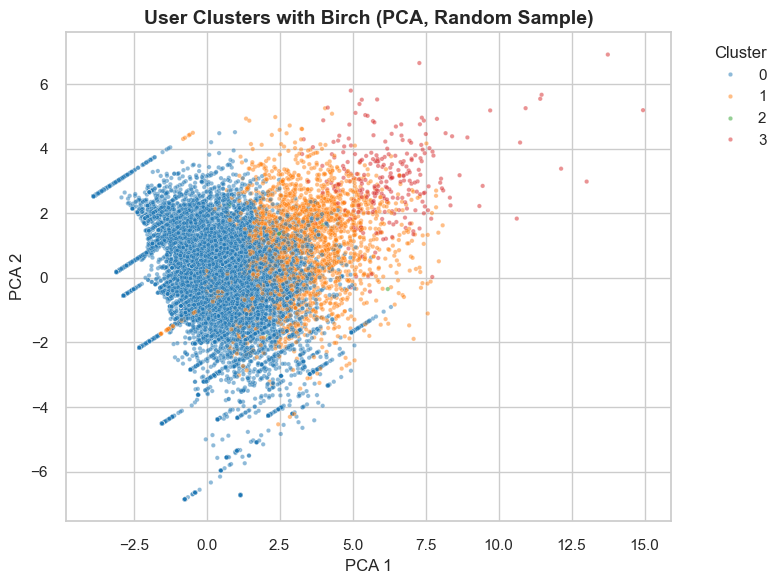

In [185]:
# PCA on X_birch feature matrix
pca_vis = PCA(n_components=2, random_state=42)
users_2d = pca_vis.fit_transform(X_birch)
df_plot = df_users.copy()
df_plot['pca1_birch'] = users_2d[:, 0]
df_plot['pca2_birch'] = users_2d[:, 1]

# Random sample from the FULL dataset
max_points = 20000  # to avoid overplotting
if len(df_plot) > max_points:
    df_plot_sample = df_plot.sample(max_points, random_state=42)
else:
    df_plot_sample = df_plot

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_plot_sample, x='pca1_birch', y='pca2_birch', hue='cluster_birch', palette='tab10', s=10, alpha=0.5)
plt.title("User Clusters with Birch (PCA, Random Sample)", fontsize=14, fontweight='bold')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.savefig("images/user_clusters_birch_pca_scatter.png", dpi=300)
plt.show()

#### Interpretation of Birch Clusters

The PCA plot shows how the four Birch clusters are positioned in a compressed 2-dimensional space.
Although PCA reduces information, it helps us visually understand how users differ in their behaviour.
Here is what each cluster represents based on its location, density, and spread:

##### **Cluster 0 (blue) — Positive Short-Term Casual Users**
This is the largest cluster.

Behavioural characteristics:
- ~7.6 total ratings (low)
- ~7.6 unique movies
- short activity spans (median ≈ 55 days)
- high average ratings (≈ 3.66)
- low rating variability (std ≈ 0.89)


**These are low-engagement, short-term visitors who interact lightly but rate positively and consistently.
They form a broad base of casual, predictable users.**

------

##### **Cluster 1 (orange) — Moderate-Activity Long-Term Users**
A large, central cluster in PCA space.

Behavioural characteristics:
- ~19 ratings
- ~19 unique movies
- very long activity spans (median ≈ 949 days)
- stable rating behaviour (avg ≈ 3.42, std ≈ 0.93)


**Steady long-term users who engage moderately but consistently.
They represent a loyal, reliable audience segment with predictable habits.**

---------

##### **Cluster 2 (green) — Super Heavy Enthusiasts / Power Users**
A small but extremely distinct cluster.

Behavioural characteristics:
- ~340 ratings (very high)
- ~231 unique movies (very high)
- long-term activity (median ≈ 720 days)
- diverse ratings (std ≈ 1.07)


**These are super-users with exceptionally high engagement.
They watch and rate hundreds of titles and remain active for years.
Their behaviour is extreme and highly influential despite their small size.**

----------

##### **Cluster 3 (red) — Long-Term Moderate Enthusiasts**
A medium-sized cluster with extremely long user histories.

Behavioural characteristics:
- ~21 total ratings
- ~21 unique movies
- longest activity spans (median ≈ 1,812 days ≈ 5 years)
- positive and steady ratings (avg ≈ 3.55, std ≈ 0.95)


**Long-term habitual users who return over many years with stable behaviour.
They engage moderately but consistently and represent a deeply loyal segment.**

### 6.4 MODEL COMPARISON

In [186]:
model_scores = pd.DataFrame({'Model': ['KMeans', 'DBSCAN', 'BIRCH'],
    'Silhouette (sample)': [kmeans_sil_score, sil_score_dbscan_final, best_sil_birch]})

model_scores.to_csv("images/user_clustering_model_scores.csv", index=True)
model_scores

,Model,Silhouette (sample)
0,KMeans,0.335
1,DBSCAN,0.205
2,BIRCH,0.487


After evaluating three clustering algorithms on a representative user sample, we obtained the silhouette scores shown above.

**K-Means** delivers strong overall performance:
- relatively high silhouette score (0.33)
- clusters are well distributed across the dataset
- segments are interpretable and reflect meaningful behavioral patterns
- captures engagement level, rating style, and activity duration  
- requires no manual feature re-weighting

This makes it a strong and stable baseline model — and consistent with course methodology.

**DBSCAN** struggles with this high-dimensional and highly skewed dataset:
- low silhouette score compared to others (0.2)
- forms one massive cluster
- many tiny fragments
- substantial noise

This behavior reflects poor cluster separability and confirms that density-based methods are not suitable for this type of user data.


**Birch** achieves the highest silhouette score (0.48), but only after feature re-weighting:
- without adjustments, Birch collapses nearly all users into one dominant cluster  
- even with tuning, it produces very broad macro-clusters that lack behavioral detail

So despite the higher silhouette score, Birch does not meet the project’s need for audience segmentation.

---

#### We Select K-Means as the Final Model
Birch scores higher, but K-Means is chosen as the final user clustering result because:

- it produces stable, well-spread clusters without feature manipulation
- clusters are interpretable and show detailed differences between audiences
- it best supports the project goals:  identifying audience segments, analyzing engagement, studying rating behaviors, comparing groups over time  

The reasoning above justifies our choice to proceed with results received by K-Means as best and final model, while including DBSCAN and Birch only as comparison methods.


### 6.5 NAMING USER CLUSTERS

To reference user groups in later sections, we assign descriptive behavioral labels:

| Cluster | Name                     |
|--------|--------------------------|
| 0      | Consistent Enjoyers      |
| 1      | Fan Visitor              |
| 2      | One-Movie Critics        |
| 3      | Loyal Ocasional Enjoyers |
| 4      | Heavy Enthusiasts        |
| 5      | Short-Term Users         |


They will be used in Section 7 to analyze how different user types engage with different movie clusters.

## SECTION 7: USER-MOVIE PREFERENCE ANALYSIS

In Section 5, we grouped movies into content types based on patterns in the data.
In the previous section, we discovered audience segments.

Here we connect the two to answer the following questions:

**→ What types of content does each user segment watch?  
→ How do they rate those content types?  
→ How do these preferences evolve over time?**


For this we use the `viewer_ratings` table from the database. Amount of data that needs to be analyzed is very extensive and includes over 4M rows.
To prevent crashing, **we never load the table into memory fully**. Instead, we only select the necessary columns and process the data in parts using pandas.

### 7.1 Merge Interactions with Clusters

We need to know, for each rating:

- which **user cluster** produced it
- which **movie cluster** it belongs to
- in which **year** it happened

We already have user and movie clusters in:

- `df_users[['customer_id', 'cluster']]`
- `df_movies[['movie_id', 'cluster']]`

We now:

1. Build **lookup dictionaries**:
   - `customer_id → user_cluster`
   - `movie_id → movie_cluster`
2. Load the `viewer_ratings` table from the database in **parts**, selecting only:
   - `customer_id`, `movie_id`, `rating`, `date`
3. For each part:
   - attach `user_cluster` and `movie_cluster`
   - compute small groupby summaries and store them for later

In [187]:
# Names for user clusters
user_cluster_names = {
    0: "Consistent Enjoyers",
    1: "Fan Visitors",
    2: "One-Movie Critics",
    3: "Loyal Occasional Enjoyers",
    4: "Heavy Enthusiasts",
    5: "Short-Term Users"
}

# Names for movie clusters
movie_cluster_names = {
    0: "Old Classics",
    1: "Well-Liked Niche Films",
    2: "Controversial Films",
    3: "Blockbusters",
    4: "Popular Films",
    5: "Hated Invisible Films"
}

In [188]:
# Look-up dictionaries from user and movie clustering
user_cluster_map = df_users.set_index('customer_id')['cluster'].to_dict()
movie_cluster_map = df_movies.set_index('movie_id')['cluster'].to_dict()

print(f"User look-up table size:  {len(user_cluster_map)}")
print(f"Movie look-up table size: {len(movie_cluster_map)}")

# Open DB connection
conn = sqlite3.connect(DB_PATH)

User look-up table size:  438780
Movie look-up table size: 16013


In [189]:
# PROCESSING DATA IN PARTS
# Containers to collect per-part summaries
pref_container = []        # user_cluster to movie_cluster
user_time_container = []   # year to user_cluster
movie_time_container = []  # year to movie_cluster

size = 400_000  # adjust if needed
part_number = 0

sql_ratings = """
    SELECT customer_id, movie_id, rating, date
    FROM viewer_ratings
"""

for part in pd.read_sql_query(sql_ratings, conn, chunksize=size, parse_dates=['date']):
    part_number += 1
    print(f"Processing part №{part_number} with {len(part)} rows...")

    # Mapping users and movies to their clusters
    part['user_cluster'] = part['customer_id'].map(user_cluster_map)
    part['movie_cluster'] = part['movie_id'].map(movie_cluster_map)

    # Only keeping rows where both mappings succeeded and rating is present
    part = part.dropna(subset=['rating', 'user_cluster', 'movie_cluster'])

    # Making sure cluster labels are stored as integers
    part['user_cluster'] = part['user_cluster'].astype(int)
    part['movie_cluster'] = part['movie_cluster'].astype(int)

    # Extract rating year
    part['rating_year'] = part['date'].dt.year

    # user_cluster and movie_cluster for preference matrix
    temp_pref = (
        part
        .groupby(['user_cluster', 'movie_cluster'])['rating']
        .agg(['sum', 'count'])    # sum of ratings, number of ratings
        .reset_index()
        .rename(columns={'sum': 'sum_rating',
                         'count': 'n_ratings'})
    )
    pref_container.append(temp_pref)

    # rating_year to user_cluster for time evolution
    temp_user_time = (
        part
        .groupby(['rating_year', 'user_cluster'])['rating']
        .size()
        .reset_index(name='n_ratings')
    )
    user_time_container.append(temp_user_time)

    # rating_year to movie_cluster for time evolution
    temp_movie_time = (
        part
        .groupby(['rating_year', 'movie_cluster'])['rating']
        .size()
        .reset_index(name='n_ratings')
    )
    movie_time_container.append(temp_movie_time)

print("Finished processing")

Processing part №1 with 400000 rows...
Processing part №2 with 400000 rows...
Processing part №3 with 400000 rows...
Processing part №4 with 400000 rows...
Processing part №5 with 400000 rows...
Processing part №6 with 400000 rows...
Processing part №7 with 400000 rows...
Processing part №8 with 400000 rows...
Processing part №9 with 400000 rows...
Processing part №10 with 400000 rows...
Processing part №11 with 25000 rows...
Finished processing


### 7.2 Building Matrices

For each pair *(user_cluster, movie_cluster)*, compute:

- **n_ratings**  → how many ratings this audience segment gave to that content type  
- **avg_rating** → how they rate that content type on average  

From these we will build:

- a **preference matrix** of average ratings (`pref_mean`)  
- a **count matrix** of rating frequencies (`pref_count`)  
- a **share matrix** (`engagement_share`) showing *what* each user cluster watches

In [190]:
# Combine all parts from container into one DataFrame
pref_all = pd.concat(pref_container, ignore_index=True)

# Count total sum of ratings and total count
pref_agg = (pref_all.groupby(['user_cluster', 'movie_cluster'])[['sum_rating', 'n_ratings']].sum()
    .reset_index()
)

# Average rating per user_cluster/movie_cluster
pref_agg['avg_rating'] = pref_agg['sum_rating'] / pref_agg['n_ratings']
pref_agg.to_csv("images/average_rating_user_movie_summary.csv", index=True)
display(pref_agg.head())

,user_cluster,movie_cluster,sum_rating,n_ratings,avg_rating
0,0,0,171413.000,46403,3.694
1,0,1,143474.000,38076,3.768
2,0,2,772574.000,225362,3.428
3,0,3,1333774.000,354768,3.760
4,0,4,1792882.000,497452,3.604


In [191]:
# PREFERENCE MATRIX
# HOW they rate (average rating)
pref_mean = (pref_agg.pivot(index='user_cluster', columns='movie_cluster', values='avg_rating').round(2))

# Create named version for interpretable display
pref_mean_named = pref_mean.rename(index=user_cluster_names, columns=movie_cluster_names)
print("Average ratings:")
pref_mean_named.to_csv("images/average_rating_summary.csv", index=True)
display(pref_mean_named)

Average ratings:


movie_cluster,Old Classics,Well-Liked Niche Films,Controversial Films,Blockbusters,Popular Films,Hated Invisible Films
user_cluster,,,,,,
Consistent Enjoyers,3.690,3.770,3.430,3.760,3.600,2.220
Fan Visitors,4.460,4.480,4.470,4.440,4.450,2.380
One-Movie Critics,2.260,2.660,2.190,2.470,2.450,1.550
Loyal Occasional Enjoyers,3.570,3.770,3.250,3.720,3.510,1.880
Heavy Enthusiasts,3.430,3.530,3.100,3.670,3.400,2.050
Short-Term Users,3.640,3.770,3.390,3.670,3.590,1.950


In [192]:
# COUNT MATRIX
# HOW MUCH they watch of each genre (rating counts)
pref_count = (pref_agg.pivot(index='user_cluster', columns='movie_cluster', values='n_ratings').fillna(0)
    .astype(int)
)

# Named version for interpretable display
pref_count_named = pref_count.rename(index=user_cluster_names, columns=movie_cluster_names)
print("Number of ratings:")
pref_count_named.to_csv("images/number_ratings_summary.csv", index=True)
display(pref_count_named)

Number of ratings:


movie_cluster,Old Classics,Well-Liked Niche Films,Controversial Films,Blockbusters,Popular Films,Hated Invisible Films
user_cluster,,,,,,
Consistent Enjoyers,46403,38076,225362,354768,497452,1079
Fan Visitors,6945,11363,33786,137906,73809,293
One-Movie Critics,2497,3364,13244,33863,14772,4335
Loyal Occasional Enjoyers,24767,19053,112102,224423,232930,1483
Heavy Enthusiasts,33512,17440,139717,67271,153045,980
Short-Term Users,27365,31762,145458,522627,367831,1417


In [193]:
# ENGAGEMENT SHARES - PROPORTIONS OF CONTENT CONSUMED BY EACH USER CLUSTER
# For each user cluster, convert counts into proportions that sum to 1
engagement_share = pref_count.div(pref_count.sum(axis=1), axis=0).round(3)

# Named version for display
engagement_share_named = engagement_share.rename(index=user_cluster_names, columns=movie_cluster_names)
print("Share of each genre in each user segment's viewing:")
engagement_share_named.to_csv("images/share_genre_in_user_segment.csv", index=True)
display(engagement_share_named)

Share of each genre in each user segment's viewing:


movie_cluster,Old Classics,Well-Liked Niche Films,Controversial Films,Blockbusters,Popular Films,Hated Invisible Films
user_cluster,,,,,,
Consistent Enjoyers,0.040,0.033,0.194,0.305,0.428,0.001
Fan Visitors,0.026,0.043,0.128,0.522,0.279,0.001
One-Movie Critics,0.035,0.047,0.184,0.470,0.205,0.060
Loyal Occasional Enjoyers,0.040,0.031,0.182,0.365,0.379,0.002
Heavy Enthusiasts,0.081,0.042,0.339,0.163,0.372,0.002
Short-Term Users,0.025,0.029,0.133,0.477,0.335,0.001


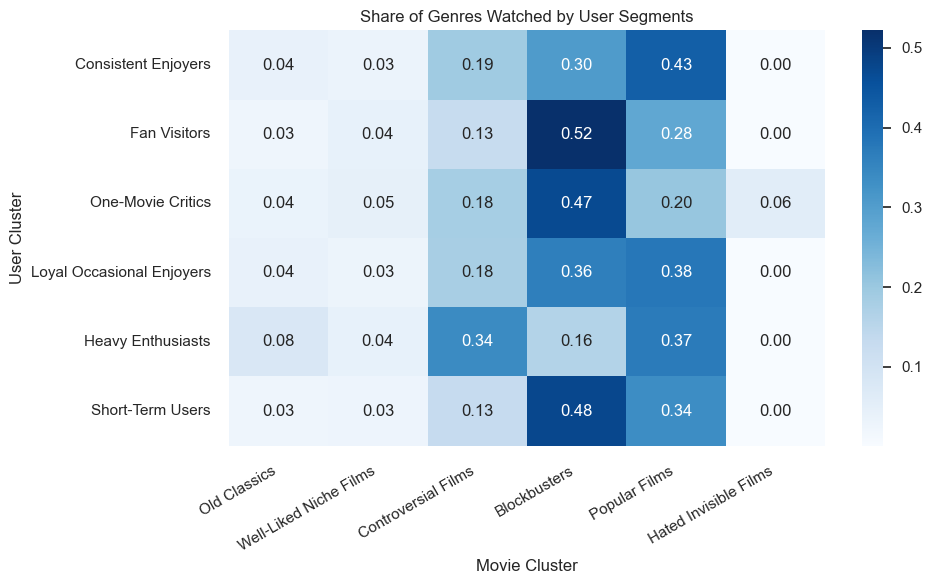

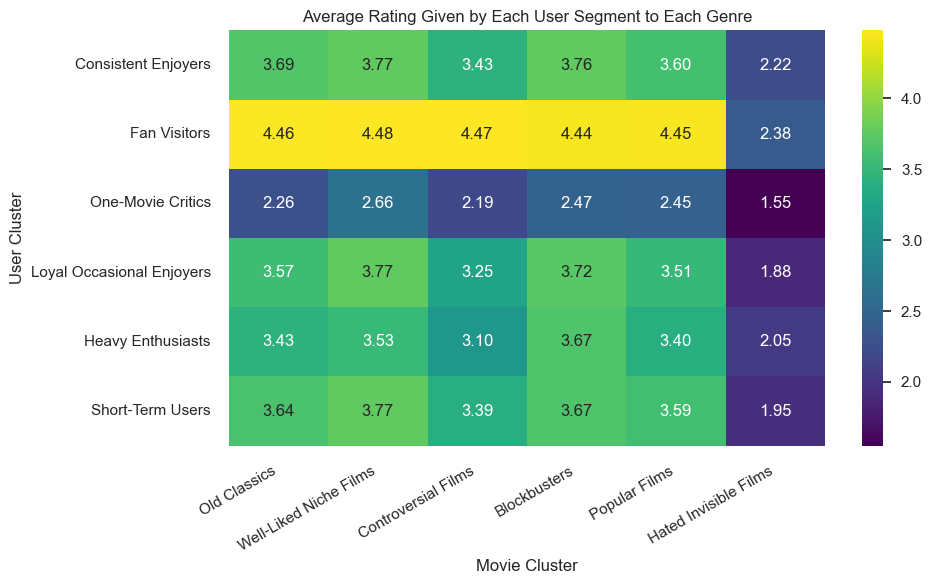

In [194]:
# PREFERENCE HEATMAPS
# WHAT they watch
plt.figure(figsize=(10, 6))
sns.heatmap(engagement_share_named, annot=True, fmt=".2f", cmap="Blues")
plt.title("Share of Genres Watched by User Segments")
plt.xlabel("Movie Cluster")
plt.ylabel("User Cluster")
plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("images/share_genres_watched_by_users.png")
plt.show()

# HOW they rate
plt.figure(figsize=(10, 6))
sns.heatmap(pref_mean_named, annot=True, fmt=".2f", cmap="viridis")
plt.title("Average Rating Given by Each User Segment to Each Genre")
plt.xlabel("Movie Cluster")
plt.ylabel("User Cluster")
plt.xticks(rotation=30, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("images/average_rating_user_segment_genre.png")
plt.show()

### 7.3 Temporal Analysis

To understand how preferences evolve over time, we use the same part summaries:

- `user_time_container`  → ratings per year from every user_cluster
- `movie_time_container` → ratings per year for every movie_cluster

From these we compute:

- how the **activity of users** changes over the years
- how the **popularity of genres** changes over the years

User cluster activity (given rating counts):


user_cluster,0,1,2,3,4,5
rating_year,,,,,,
1995,0,39,57,21,0,6
1996,0,42,52,22,0,3
1997,0,38,58,17,0,2
1998,0,138,177,76,2,9
1999,5,709,869,331,12,50


User cluster activity (given rating shares):


user_cluster,0,1,2,3,4,5
rating_year,,,,,,
1995,0.000,0.317,0.463,0.171,0.000,0.049
1996,0.000,0.353,0.437,0.185,0.000,0.025
1997,0.000,0.330,0.504,0.148,0.000,0.017
1998,0.000,0.343,0.440,0.189,0.005,0.022
1999,0.003,0.359,0.440,0.168,0.006,0.025


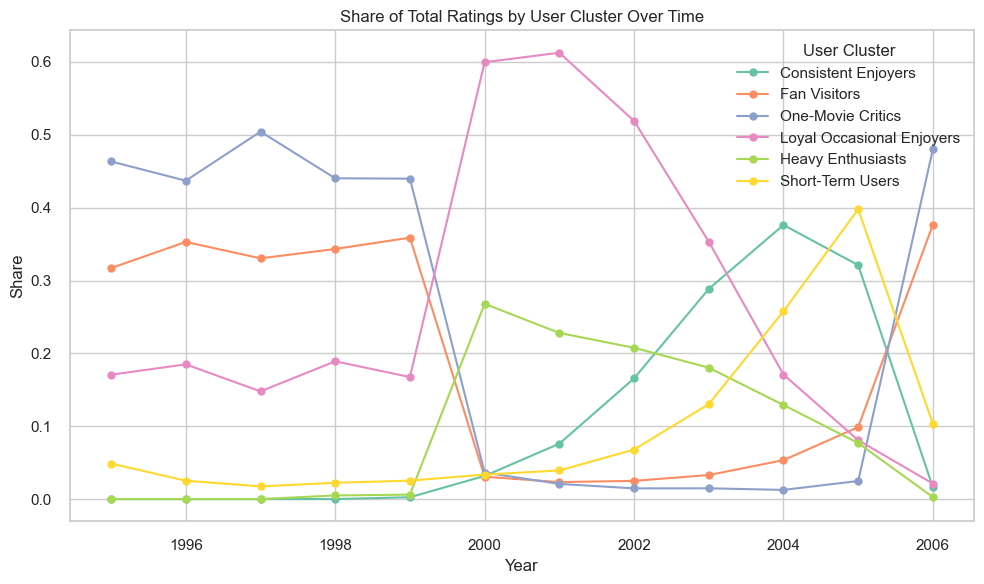

In [195]:
# USER CLUSTER'S ACTIVITY OVER TIME
# Combine and aggregate: rating_year and user_cluster
user_time_all = pd.concat(user_time_container, ignore_index=True)

user_time_agg = (user_time_all.groupby(['rating_year', 'user_cluster'])['n_ratings'].sum().reset_index())

yearly_user_counts = (user_time_agg.pivot(index='rating_year', columns='user_cluster', values='n_ratings')
    .fillna(0)
    .astype(int)
    .sort_index()
)

yearly_user_share = yearly_user_counts.div(yearly_user_counts.sum(axis=1), axis=0)

print("User cluster activity (given rating counts):")
display(yearly_user_counts.head())

print("User cluster activity (given rating shares):")
display(yearly_user_share.head())

# PLOT RESULTS
plt.figure(figsize=(10,6))
for c in yearly_user_share.columns:
    plt.plot(yearly_user_share.index, yearly_user_share[c], marker='o', label=user_cluster_names[c])

plt.title("Share of Total Ratings by User Cluster Over Time")
plt.xlabel("Year")
plt.ylabel("Share")
plt.grid(True, axis='y')
plt.legend(title="User Cluster")
plt.tight_layout()
plt.savefig("images/user_total_share_over_time.png")
plt.show()

Movie cluster popularity (received rating counts):


movie_cluster,0,1,2,3,4,5
rating_year,,,,,,
1995,11,42,44,0,1,25
1996,11,36,38,0,0,34
1997,9,34,39,0,1,32
1998,70,108,127,0,0,97
1999,322,544,651,4,40,415


Movie cluster popularity (received rating shares):


movie_cluster,0,1,2,3,4,5
rating_year,,,,,,
1995,0.089,0.341,0.358,0.000,0.008,0.203
1996,0.092,0.303,0.319,0.000,0.000,0.286
1997,0.078,0.296,0.339,0.000,0.009,0.278
1998,0.174,0.269,0.316,0.000,0.000,0.241
1999,0.163,0.275,0.329,0.002,0.020,0.210


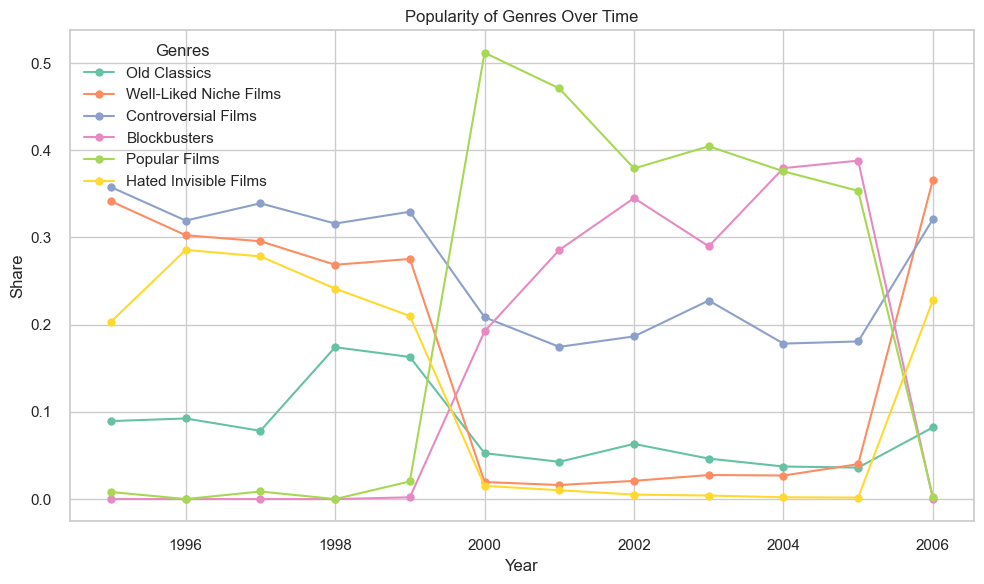

Database connection closed


In [196]:
# MOVIE GENRE'S POPULARITY OVER TIME
# Combine and aggregate: rating_year and movie_cluster
movie_time_all = pd.concat(movie_time_container, ignore_index=True)

movie_time_agg = (movie_time_all.groupby(['rating_year', 'movie_cluster'])['n_ratings'].sum().reset_index())

yearly_movie_counts = (movie_time_agg.pivot(index='rating_year', columns='movie_cluster', values='n_ratings')
    .fillna(0)
    .astype(int)
    .sort_index()
)

yearly_movie_share = yearly_movie_counts.div(yearly_movie_counts.sum(axis=1), axis=0)

# PLOT RESULTS
print("Movie cluster popularity (received rating counts):")
yearly_movie_counts.to_csv("images/Movie_cluster_popularity_counts.csv", index=True)
display(yearly_movie_counts.head())
print("Movie cluster popularity (received rating shares):")
yearly_movie_share.to_csv("images/Movie_cluster_popularity_shares.csv", index=True)
display(yearly_movie_share.head())

plt.figure(figsize=(10,6))
for c in yearly_movie_share.columns:
    plt.plot(yearly_movie_share.index, yearly_movie_share[c], marker='o', label=movie_cluster_names[c])

plt.title("Popularity of Genres Over Time")
plt.xlabel("Year")
plt.ylabel("Share")
plt.grid(True, axis='y')
plt.legend(title="Genres")
plt.tight_layout()
plt.savefig("images/movie_cluster_popularity_over_time.png")
plt.show()

# ANALYSIS IS FINISHED -  CLOSE DB
conn.close()
print("Database connection closed")

## 7.4 PROJECT DISCOVERIES

### What Each User Segment Watches?

We combine user behavioural traits (volume, activity span, rating style) with movie-cluster taste preferences (engagement shares and average ratings) to form clear audience personas.

---

#### **Consistent Enjoyers (Cluster 0)**
**Behaviour:** Moderate–high activity, broad exploration, stable positive ratings.

**Viewing:** Mostly **Popular Films (43%)** and **Blockbusters (30%)**; some **Controversial Films (19%)**.

**Taste:** Strong ratings for well-liked and mainstream titles (≈3.7–3.8).

**Insight:** A reliable, satisfied core audience focused on mainstream content.

---

#### **Fan Visitors (Cluster 1)**
**Behaviour:** Minimal activity, extremely generous rating style.

**Viewing:** Primarily **Blockbusters (52%)**, then **Popular Films (28%)**.

**Taste:** Highest ratings across all clusters (4.4+).

**Insight:** One-session users drawn to trending films; high positivity without retention.

---

#### **One-Movie Critics (Cluster 2)**
**Behaviour:** Very low activity, harsh rating patterns.

**Viewing:** **Blockbusters (47%)**, **Popular Films (20%)**, notable **Controversial Films (18%)**; only group engaging with **Invisible Films (6%)**.

**Taste:** Lowest ratings in all categories (1.5–2.6).

**Insight:** Critical visitors who explore unusual content but rarely enjoy it.

---

#### **Loyal Occasional Enjoyers (Cluster 3)**
**Behaviour:** Light but long-term activity (multi-year), steady positive ratings.

**Viewing:** Split between **Popular Films (38%)** and **Blockbusters (36%)**.

**Taste:** Consistently positive for mainstream content (≈3.5–3.7).

**Insight:** Rarely active but highly loyal mainstream viewers.

---

#### **Heavy Enthusiasts (Cluster 4)**
**Behaviour:** Highest engagement, broad exploration, moderate–positive ratings.

**Viewing:** More diverse: **Controversial Films (34%)**, **Popular Films (37%)**, **Classics (8%)**, fewer Blockbusters.

**Taste:** Appreciates niche and older films (≈3.4–3.5); realistic scoring.

**Insight:** Deep catalog explorers who enrich platform depth.

---

#### **Short-Term Users (Cluster 5)**
**Behaviour:** Light–moderate short-term activity, neutral ratings.

**Viewing:** **Blockbusters (48%)** and **Popular Films (34%)** dominate.

**Taste:** Good ratings for mainstream (≈3.6), much lower for fringe categories.

**Insight:** Trial-phase users who watch promoted films but rarely stay.

---

### How Each User Segment Rates Content (pref_mean)

- **Fan Visitors** inflate all ratings (4.4+).
- **Consistent Enjoyers**, **Loyal Occasional**, and **Heavy Enthusiasts** form the realistic positive-rating base (3.4–3.8).
- **Short-Term Users** resemble Enjoyers but drop sharply on niche content.
- **One-Movie Critics** rate all clusters poorly.

**Insight:** Rating style alone already separates long-term stable users from temporary or dissatisfied ones.

---

### Temporal Behavior of User Segments

- **1999–2001:** *Loyal Occasional Enjoyers* temporarily dominate rating activity.
- **Post-2001:** *Consistent Enjoyers* and *Heavy Enthusiasts* rise steadily and become the key long-term segments.
- *Fan Visitors* and *Short-Term Users* decline over time.
- *One-Movie Critics* remain small and stable.

**Insight:** Over time, the audience shifts toward more stable and engaged user groups.

---

### Temporal Behavior of Movie Clusters

- **Popular Films** surge after 1999 and stay dominant.
- **Blockbusters** rise sharply after 2000.
- **Niche and Invisible Films** steadily decline.
- **Old Classics** remain marginal but persistent.
- **Controversial Films** stay mid-tier.

**Insight:** The platform matures toward mainstream consumption, with niche categories losing influence.

---

### Combined Insights: Which Segments Match Which Genres?

- **Consistent Enjoyers → Popular Films & Blockbusters**
- **Fan Visitors → Blockbusters & Popular Films**
- **Loyal Occasional Enjoyers → Popular Films & Blockbusters**
- **Heavy Enthusiasts → Controversial Films & Classics**
- **One-Movie Critics → Controversial & Invisible Films**
- **Short-Term Users → Blockbusters & Popular Films**

---

### Final Summary

- Mainstream clusters (Blockbusters, Popular Films) dominate almost all user groups.
- Niche, controversial, and invisible films appeal mainly to Enthusiasts or Critics.
- Engagement patterns clearly differentiate long-term valuable users from short-term ones.
- **Consistent Enjoyers, Loyal Occasional Enjoyers, and Heavy Enthusiasts** emerge as the platform’s most strategic segments.
- The ecosystem shifts over time toward mainstream, high-engagement content.

These combined behavioural, preference, and temporal patterns provide a full decoding of the platform’s audience and the content that sustains it.